### This notebook implements the SSSR method on the Kennedy Space Center Hyperspectral Image

Imports

In [1]:
import numpy as np
import cv2 
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import io as iot
import sys
import time
from matplotlib import pyplot
import tensorflow as tf
import random
from spectral import *
from scipy.special import gamma, kv, erf
from scipy.signal import convolve2d
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer
from tqdm import tqdm
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

2025-07-09 11:24:56.040445: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-09 11:24:56.065043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-09 11:24:56.080682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-09 11:24:56.086548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-09 11:24:56.101376: I tensorflow/core/platform/cpu_feature_guar

In [2]:
def set_random_seed(seed=42):
    """
    Sets the random seed for reproducibility in TensorFlow, NumPy, and Python.
    Also sets TF deterministic ops.
    """
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Optional: Force deterministic operations
    try:
        tf.config.experimental.enable_op_determinism()
    except AttributeError:
        # Older TF version fallback
        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        
set_random_seed(42)

Helper Functions

In [3]:
# Defining each PSF

kernel_size = 7
sigma = 3.40

def gaussian_psf(sigma, psf_size):
    """Generate a Gaussian PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    psf = np.exp(-(X**2 + Y**2) / (2 * sigma**2))
    psf = psf / psf.sum()
    return psf
gaus_psf = gaussian_psf(sigma, kernel_size)

def kolmogorov_psf(sigma, psf_size):
    """Generate a Kolmogorov PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-(r / sigma)**(5/3))
    psf = psf / psf.sum()
    return psf
kol_psf = kolmogorov_psf(sigma, kernel_size)

def airy_psf(sigma, psf_size):
    """Generate an Airy PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    z = (2.33811 * r) / sigma
    psf = (2 * kv(1, z) / z)**2
    psf[r == 0] = 1
    psf = psf / psf.sum()
    return psf
air_psf = airy_psf(sigma, kernel_size)

def moffat_psf(sigma, psf_size, beta=3.5):
    """Generate a Moffat PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = (1 + (r / sigma)**2)**(-beta)
    psf = psf / psf.sum()
    return psf
mof_psf = moffat_psf(sigma, kernel_size)

def sinc_psf(sigma, psf_size):
    """Generate a Sinc PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.sinc(r / sigma)
    psf = psf / psf.sum()
    return psf
sinc_psf = sinc_psf(sigma, kernel_size)

def lorentzian_squared_psf(sigma, psf_size):
    """Generate a Lorentzian Squared PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = 1 / (1 + (r / sigma)**4)
    psf = psf / psf.sum()
    return psf
lor_sq_psf = lorentzian_squared_psf(sigma, kernel_size)

def hermite_psf(sigma, psf_size, n=1):
    """Generate a Hermite PSF."""
    from numpy.polynomial.hermite import hermval
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.exp(-r**2 / (2 * sigma**2)) * hermval(r / sigma, [0]*n + [1])
    psf = psf / psf.sum()
    return psf
her_psf = hermite_psf(sigma, kernel_size)

def parabolic_psf(sigma, psf_size):
    """Generate a Parabolic PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    r = np.sqrt(X**2 + Y**2)
    psf = np.maximum(0, 1 - (r / sigma)**2)
    psf = psf / psf.sum()
    return psf
par_psf = parabolic_psf(sigma, kernel_size)

def gabor_psf(sigma, psf_size, theta=0, lambd=1, gamma=0.5, psi=0):
    """Generate a Gabor PSF."""
    x = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    y = np.linspace(-psf_size, psf_size, 2*psf_size+1)
    X, Y = np.meshgrid(x, y)
    x_theta = X * np.cos(theta) + Y * np.sin(theta)
    y_theta = -X * np.sin(theta) + Y * np.cos(theta)
    psf = np.exp(-0.5 * (x_theta**2 + gamma**2 * y_theta**2) / sigma**2) * np.cos(2 * np.pi * x_theta / lambd + psi)
    psf = psf / psf.sum()
    return psf
gab_psf = gabor_psf(sigma, kernel_size)

def delta_function_psf(sigma, psf_size):
    """Generate a Delta Function PSF."""
    psf = np.zeros((2*psf_size+1, 2*psf_size+1))
    psf[psf_size, psf_size] = 1
    return psf
delta_psf = delta_function_psf(sigma, kernel_size)

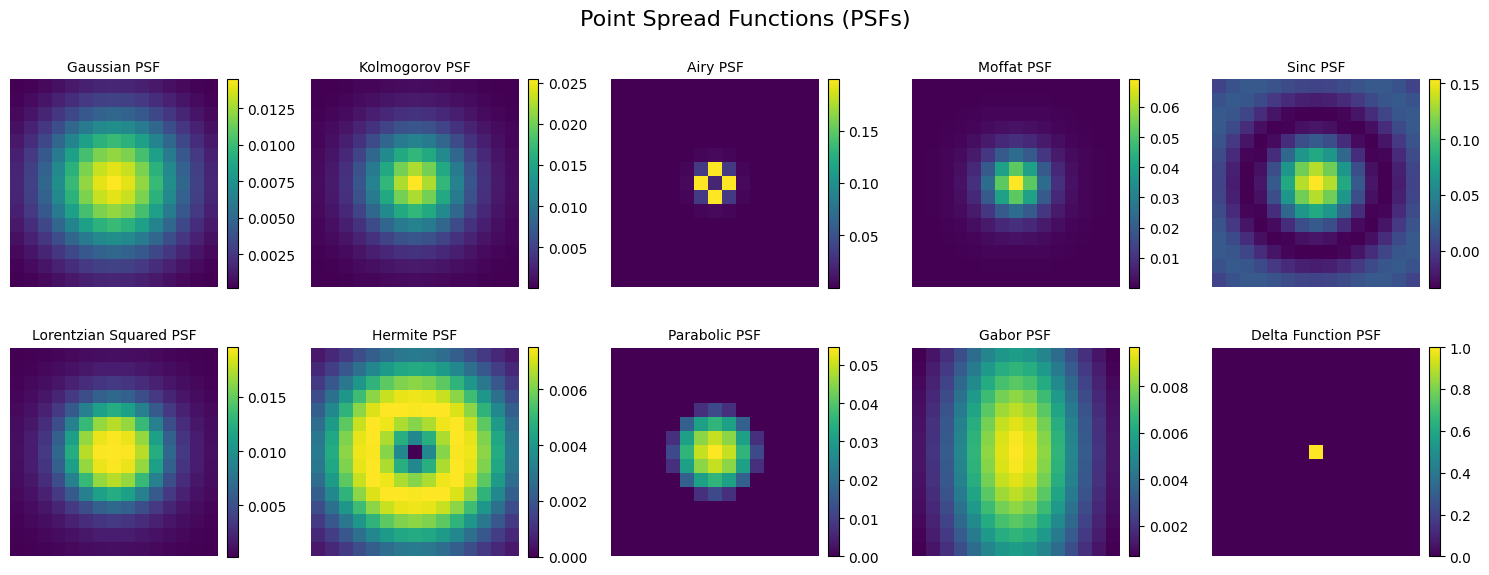

In [4]:
# Visualizing all the PSFs that will be used

psfs = [
    (gaus_psf, "Gaussian PSF"),
    (kol_psf, "Kolmogorov PSF"),
    (air_psf, "Airy PSF"),
    (mof_psf, "Moffat PSF"),
    (sinc_psf, "Sinc PSF"),
    (lor_sq_psf, "Lorentzian Squared PSF"),
    (her_psf, "Hermite PSF"),
    (par_psf, "Parabolic PSF"),
    (gab_psf, "Gabor PSF"),
    (delta_psf, "Delta Function PSF")
]

# Create subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 5 columns, 2 rows
fig.suptitle("Point Spread Functions (PSFs)", fontsize=16)

# Plot each PSF
for i, (psf, label) in enumerate(psfs):
    ax = axes[i // 5, i % 5]  # Determine subplot position
    im = ax.imshow(psf, cmap='viridis')
    ax.set_title(label, fontsize=10)
    ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
# Function to apply PSF to an image
def apply_psf(image, psf):
    
    """
    Convolve each channel of 'image' with 'psf' using 'same' padding.

    Parameters:
    -----------
    image : np.ndarray
        Shape (height, width, channels).
    psf   : np.ndarray
        Shape (kernel_height, kernel_width).
        
    Returns:
    --------
    blurred_image : np.ndarray
        Same shape as input image (height, width, channels).
    """
    
    # Prepare an output array of the same shape as 'image'
    blurred_image = np.zeros_like(image, dtype=np.float32)

    # Convolve each channel separately
    channels = image.shape[2]
    for c in range(channels):
        # convolve2d with mode='same' replicates TensorFlow's 'SAME' padding
        blurred_image[:, :, c] = convolve2d(image[:, :, c], psf, mode='same')
        
    return blurred_image
    
# Function to downsample an image
def downsample_image(image, factor):
    # Ensure the input image is a NumPy array
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    
    # Get the dimensions of the image
    height, width, channels = image.shape
    
    # Initialize a list to hold the downsampled channels
    downsampled_channels = []
    
    # Downsample each channel individually
    for c in range(channels):
        channel = image[:, :, c]
        downsampled_channel = cv2.resize(channel, (width // factor, height // factor), interpolation=cv2.INTER_AREA)
        downsampled_channels.append(downsampled_channel)
    
    # Stack the downsampled channels back together
    downsampled_image = np.stack(downsampled_channels, axis=-1)
    
    return downsampled_image
    
# Function to add noise to an image
def add_awgn_noise(hsi_image, SNR_dB):
    
    """
    Add AWGN (Additive White Gaussian Noise) to the input hsi_image,
    given a desired SNR in dB. Uses NumPy only.

    Parameters
    ----------
    hsi_image : np.ndarray
        Input image of shape (rows, cols, channels).
    SNR_dB : float
        Desired SNR in decibels.

    Returns
    -------
    noisy_hsi_image : np.ndarray
        Noisy image of the same shape as hsi_image.
    """

     # Ensure float32
    hsi_image = hsi_image.astype(np.float32)

    rows, cols, channels = hsi_image.shape

    # Compute the signal power for each channel
    # shape: (channels,)
    signal_power = np.mean(hsi_image ** 2, axis=(0, 1))

    # Convert SNR from dB to linear scale
    SNR_linear = 10 ** (SNR_dB / 10.0)

    # Compute noise power and noise standard deviation per channel
    noise_power = signal_power / SNR_linear  # shape: (channels,)
    noise_std = np.sqrt(noise_power)         # shape: (channels,)

    # Reshape for broadcasting across (rows, cols)
    noise_std = noise_std.reshape((1, 1, channels))

    # Generate white Gaussian noise
    noise = np.random.normal(
        loc=0.0, 
        scale=1.0, 
        size=(rows, cols, channels)
    ).astype(np.float32)

    # Scale noise by the computed standard deviation
    noise *= noise_std

    # Add noise to the original image
    noisy_hsi_image = hsi_image + noise

    return noisy_hsi_image
    
# Function to normalize an image between 0 and 1 safely
def normalize(image):
    """
    Normalize an image to the range [0, 1] while clipping outliers.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image with arbitrary range values.
    
    Returns:
    --------
    normalized_image : np.ndarray
        Normalized image in range [0, 1].
    """
    min_val, max_val = np.percentile(image, [1, 99])
    return (np.clip(image, min_val, max_val) - min_val) / (max_val - min_val)

# Function to obtain the Spectral Response Function for spectral degradation
def get_srf_bands(num_bands: int) -> np.ndarray:
    """
    Return a (num_bands, 3) array of [center_nm, low_edge_nm, high_edge_nm]
    matching the specified 'num_bands' from {1,3,4,8,16}.
    
    1-band  => IKONOS Panchromatic
    3-bands => IKONOS RGB
    4-bands => IKONOS B, G, R, NIR
    8-bands => WorldView-2 
    16-bands => WorldView-3

    Raises ValueError if num_bands is not in [1,3,4,8,16].
    """

    if num_bands == 1:
        # IKONOS panchromatic
        band_specs = np.array([
            [729.0, 409.0, 1048.0]  # center, lower, upper
        ], dtype=np.float32)
    
    elif num_bands == 3:
        # IKONOS RGB
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
        ], dtype=np.float32)
    
    elif num_bands == 4:
        # IKONOS B, G, R, NIR
        band_specs = np.array([
            [480.0, 421.0, 539.0],  # Blue
            [552.0, 480.0, 624.0],  # Green
            [666.0, 602.0, 729.0],  # Red
            [803.0, 713.0, 893.0],  # NIR
        ], dtype=np.float32)

    elif num_bands == 8:
        # WorldView-2
        band_specs = np.array([
            [427.0, 396.0, 458.0],  # Coastal Blue
            [478.0, 442.0, 515.0],  # Blue
            [546.0, 506.0, 586.0],  # Green
            [608.0, 584.0, 632.0],  # Yellow
            [659.0, 624.0, 694.0],  # Red
            [724.0, 699.0, 749.0],  # Red Edge
            [833.0, 765.0, 901.0],  # NIR1
            [949.0, 856.0, 1043.0], # NIR2
        ], dtype=np.float32)
    
    elif num_bands == 16:
        # WorldView-3
        band_specs = np.array([
            [426.0, 397.0, 454.0],    # Coastal Blue
            [481.0, 445.0, 517.0],    # Blue
            [547.0, 507.0, 586.0],    # Green
            [605.0, 580.0, 629.0],    # Yellow
            [661.0, 626.0, 696.0],    # Red
            [724.0, 698.0, 749.0],    # Red Edge
            [832.0, 765.0, 899.0],    # NIR1
            [948.0, 857.0, 1039.0],   # NIR2
            [1210.0, 1184.0, 1235.0], # SWIR1
            [1572.0, 1546.0, 1598.0], # SWIR2
            [1661.0, 1636.0, 1686.0], # SWIR3
            [1730.0, 1702.0, 1759.0], # SWIR4
            [2164.0, 2137.0, 2191.0], # SWIR5
            [2203.0, 2174.0, 2232.0], # SWIR6
            [2260.0, 2228.0, 2292.0], # SWIR7
            [2329.0, 2285.0, 2373.0], # SWIR8
        ], dtype=np.float32)
    
    else:
        raise ValueError(f"Unsupported num_bands={num_bands}. Must be 1,3,4,8, or 16.")

    return band_specs
    
# Function to apply SRF to an image
def apply_srf(
    hyper_image: np.ndarray,
    band_specs: np.ndarray,
    fwhm_factor: float = 4.2
):
    """
    Apply a Gaussian-based SRF (based on band_specs) to the given HR hyperspectral image.
    
    Unlike the previous version, this function infers the number of HSI bands (L) 
    from hyper_image.shape, and automatically constructs a linearly-spaced 
    wavelength array from the minimum lower_edge to the maximum upper_edge 
    in band_specs.

    Parameters
    ----------
    hyper_image : np.ndarray
        (rows, cols, L) float32 (or will be converted). The high-resolution HSI.
    band_specs : np.ndarray
        (num_bands, 3) array, each row = [center_nm, low_edge_nm, upper_edge_nm].
        Examples: 
            - 1-band IKONOS Panchromatic 
            - 3-band IKONOS RGB 
            - 4-band IKONOS (B,G,R,NIR) 
            - 8-band WorldView-2 
            - 16-band WorldView-3
        etc.
    fwhm_factor : float
        Factor to convert from (upper_edge - lower_edge) to approximate standard deviation.
        By default 4.2, typical ratio (FWHM / (2.355...) or so for a Gaussian).

    Returns
    -------
    ms_image : np.ndarray
        (rows, cols, num_bands). The resulting multi/pan/RGB image.
    srf : np.ndarray
        (num_bands, L). The spectral response function for each output band
        across the L inferred HSI wavelength positions.
    auto_wavelengths : np.ndarray
        (L,) The automatically-generated wavelength array spanning 
        [min_lower_edge, max_upper_edge].
    """

    # 1) Ensure float32
    hyper_image = hyper_image.astype(np.float32)
    rows, cols, L = hyper_image.shape

    # 2) Determine the min/max edges from band_specs
    #    We will assume the entire HSI covers this range uniformly.
    #    E.g. for IKONOS Panchromatic: [409, 1048], etc.
    min_lower_edge = band_specs[:, 1].min()
    max_upper_edge = band_specs[:, 2].max()

    # 3) Construct a linearly-spaced wavelength array of length L
    #    from min_lower_edge to max_upper_edge, inclusive
    auto_wavelengths = np.linspace(min_lower_edge, max_upper_edge, L).astype(np.float32)
    # Shape: (L,)  We'll reshape to (1, L) for broadcasting
    wave_2d = auto_wavelengths[None, :]  # shape => (1, L)

    # 4) Prepare the SRF array
    num_bands = band_specs.shape[0]
    srf = np.zeros((num_bands, L), dtype=np.float32)

    for i in range(num_bands):
        center_nm = band_specs[i, 0]
        low_nm    = band_specs[i, 1]
        high_nm   = band_specs[i, 2]

        # approximate standard deviation from (high - low) / fwhm_factor
        std_nm = (high_nm - low_nm) / fwhm_factor

        # Gaussian SRF across all L wavelengths
        # shape => (1, L); after the operation => (L,) effectively
        srf_i = np.exp(-0.5 * ((wave_2d - center_nm) / std_nm) ** 2)

        # Normalize so the sum of srf_i is 1 across the L channels
        sum_i = srf_i.sum()
        if sum_i > 1e-8:
            srf_i /= sum_i

        srf[i, :] = srf_i

    # 5) Now srf has shape (num_bands, L). We want to apply it to hyper_image:
    #    hyper_image: (rows, cols, L)
    #    srf^T: (L, num_bands)
    # => tensordot => (rows, cols, num_bands)
    srf_t = srf.T  # shape => (L, num_bands)
    ms_image = np.tensordot(hyper_image, srf_t, axes=([2], [0]))  # => (rows, cols, num_bands)

    # 6) Convert to float32
    ms_image = ms_image.astype(np.float32)

    return ms_image, srf, auto_wavelengths

Functions to visualize the inputs

In [6]:
# Function to visualize an HSI
def visualize_hsi(img, bands, title):
    """
    Visualize a hyperspectral image by converting it to an RGB representation.
    
    Parameters:
    -----------
    img : np.ndarray
        Hyperspectral image array.
    bands : tuple
        Band indices to use for RGB representation.
    title : str
        Title for the plot.
    """
    img_rgb = get_rgb(img, bands)
    plt.figure(figsize=(10, 10))
    plt.imshow(img_rgb)
    plt.title(title)
    plt.axis('on')
    plt.show()

# Function to visualize an MSI/RGB/Panchromatic image along with the SRF
def plot_multispectral_with_srf(ms_image, bands, title, srf, wavelengths, ikonos_bands):
    """
    Visualize a multispectral (or RGB/panchromatic) image alongside its Spectral Response Function (SRF).
    
    Parameters
    ----------
    ms_image : np.ndarray
        Multispectral image, shape: (rows, cols, num_bands).
    bands : tuple
        Band indices to use for RGB representation (only used if num_bands >= 3).
    title : str
        Title for the image plot.
    srf : np.ndarray
        Spectral Response Function, shape: (num_bands, L).
    wavelengths : np.ndarray
        Wavelengths corresponding to the L hyperspectral bands (x-axis for SRF).
    ikonos_bands : np.ndarray
        An array with shape (num_bands, 3) containing [center_nm, low_edge_nm, high_edge_nm]
        for each band. It is used here just to show the center wavelength in the legend.
    
    Notes
    -----
    - This function assumes num_bands is one of {1,3,4,8,16}.
    - If num_bands=1, we skip get_rgb and just display a grayscale single-band image.
    - If num_bands=3,4,8,16, we attempt to display an RGB image using 'bands' for the channel ordering.
    - The SRF curve colors and labels are chosen via if/elif blocks, 
      matching each possible number of bands.
    """
    num_bands = ms_image.shape[2]  # e.g. 1,3,4,8,16

    # 1) Choose band labels & colors depending on how many bands we have
    if num_bands == 1:
        band_labels = ["Panchromatic"]
        band_colors = ["k"]
    elif num_bands == 3:
        band_labels = ["Blue", "Green", "Red"]
        band_colors = ["b", "g", "r"]
    elif num_bands == 4:
        band_labels = ["Blue", "Green", "Red", "NIR"]
        band_colors = ["b", "g", "r", "k"]
    elif num_bands == 8:
        band_labels = ["Coastal", "Blue", "Green", "Yellow", 
                       "Red", "Red Edge", "NIR1", "NIR2"]
        # You can pick any 8 distinct colors you like:
        band_colors = ["b", "g", "r", "c", "m", "y", "k", "orange"]
    elif num_bands == 16:
        band_labels = [
            "Coastal Blue", "Blue", "Green", "Yellow", 
            "Red", "Red Edge", "NIR1", "NIR2",
            "SWIR1", "SWIR2", "SWIR3", "SWIR4",
            "SWIR5", "SWIR6", "SWIR7", "SWIR8"
        ]
        # Again, pick any 16 distinct colors you like:
        band_colors = [
            "b", "g", "r", "c", "m", "y", "k", "orange", 
            "purple", "brown", "pink", "gray", 
            "olive", "navy", "teal", "maroon"
        ]
    else:
        raise ValueError("Function only supports images with 1, 3, 4, 8, or 16 bands.")
    
    # 2) Create the figure with 2 subplots (image on the left, SRF on the right)
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # 3) Plot the image
    if num_bands == 1:
        # Just display the single-band image in grayscale
        single_band_2d = ms_image[:, :, 0]  # shape (rows, cols)
        axs[0].imshow(single_band_2d, cmap="gray")
        axs[0].set_title(title + " (Single-Band/Panchromatic)")
    else:
        # We have at least 3 bands, so let's form an RGB image
        img_rgb = get_rgb(ms_image, bands)
        axs[0].imshow(img_rgb)
        axs[0].set_title(title)
    axs[0].axis('off')
    
    # 4) Plot the SRF curves in the second subplot
    for i in range(num_bands):
        center_nm = ikonos_bands[i, 0]  # The 'center' column from your band_specs
        axs[1].plot(
            wavelengths,
            srf[i, :],
            label=f'{band_labels[i]} (Center: {center_nm} nm)',
            color=band_colors[i]
        )
    axs[1].set_xlabel('Wavelength (nm)')
    axs[1].set_ylabel('Spectral Response')
    axs[1].set_title('Spectral Response Functions (SRF)')
    axs[1].legend()
    axs[1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
# Function to plot the spectra at input pixels  
def plot_spectra(ground_truth_hsi, super_resolved_hsi, x, y):
    """
    Plotting the spectra of two hyperspectral images at a specific pixel location.
    
    Inputs:
    ground_truth_hsi (numpy.ndarray): The ground truth hyperspectral image
    super_resolved_hsi (numpy.ndarray): The super resolved hyperspectral image (output of model)
    x (int): The x pixel location
    y (int): The y pixel location
    """
    
    ground_truth_hsi = ground_truth_hsi.astype(np.float32)
    super_resolved_hsi = super_resolved_hsi.astype(np.float32)
    
    # Extract the spectra at the specific pixel location (x,y)
    ground_truth_spectra = ground_truth_hsi[y, x, :]
    super_resolved_spectra = super_resolved_hsi[y, x, :]
    
    # Number of spectral bands
    num_bands = ground_truth_hsi.shape[2]
    print("Number of bands = ", num_bands)
    
    # Plot the spectra
    plt.figure(figsize=(10,5))
    plt.plot(range(num_bands), ground_truth_spectra, label='Ground Truth Spectra')
    plt.plot(range(num_bands), super_resolved_spectra, label='Super Resolved Spectra')
    
    # Add labels and title
    plt.xlabel('Spectral band')
    plt.ylabel('Reflectance')
    plt.title(f'Spectra at pixel location (x={x}, y={y})')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Synthetic input generation functions

In [7]:
# Function to spatially degrade an image
def spatial_degradation(image, psf, downsample_ratio, SNR):
    """
    Apply spatial degradation to an image.
    
    Parameters:
    -----------
    image : np.ndarray
        Input image.
    psf : np.ndarray
        Point Spread Function.
    downsample_ratio : int
        Factor by which to downsample.
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    
    Returns:
    --------
    degraded_image : np.ndarray
        Spatially degraded image.
    """
    I_HS = normalize(image)
    I_HS = apply_psf(I_HS, psf)
    I_HS = downsample_image(I_HS, downsample_ratio)
    I_HS = add_awgn_noise(I_HS, SNR)
    return I_HS

# Function to spectrally degrade an image
def spectral_degradation(image, SNR, num_bands=4, fwhm_factor=4.3):
    """
    Apply spectral degradation to an image.
    
    Parameters
    ----------
    image : np.ndarray
        Input HSI image, shape (rows, cols, L).
    SNR : float
        Signal-to-Noise Ratio for noise addition.
    num_bands : int
        Desired number of output bands. Must be one of {1,3,4,8,16}.
        1 => IKONOS Panchromatic
        3 => IKONOS RGB
        4 => IKONOS B/G/R/NIR
        8 => WorldView-2
        16 => WorldView-3
    fwhm_factor : float
        Factor to approximate std dev from (upper_edge - lower_edge).
        Default=4.2 is typical for a rough Gaussian FWHM approximation.

    Returns
    -------
    I_MS : np.ndarray
        Spectrally degraded image of shape (rows, cols, num_bands).
    srf : np.ndarray
        The sensor SRF curves, shape (num_bands, L).
    band_specs : np.ndarray
        The band specs used, shape (num_bands, 3).
    auto_wavelengths : np.ndarray
        The automatically generated wavelengths, shape (L,).
    """
    
    # 1) Fetch the band specs for the desired sensor configuration
    band_specs = get_srf_bands(num_bands)

    # 2) Normalize the image to [0,1] (or however your normalize function works)
    I_MS = normalize(image)

    # 3) Apply the SRF to produce the 'multispectral' (or panchromatic/RGB) image
    I_MS, srf, auto_wavelengths = apply_srf(I_MS, band_specs, fwhm_factor=fwhm_factor)

    # 4) Add AWGN noise
    I_MS = add_awgn_noise(I_MS, SNR)

    # 5) Return the result plus info you might need for plotting or further usage
    return I_MS, srf, band_specs, auto_wavelengths

Importing and degrading the KSC HSI

In [8]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the dataset
dataset_relative_path = "../../../Datasets/Synthetic_data/"

# Construct the full path to the dataset
dataset_path = os.path.join(notebook_directory, dataset_relative_path)

# Normalize the path to remove redundancies
normalized_dataset_path = os.path.normpath(dataset_path)

# Define the data file path
mat_file_path = os.path.join(normalized_dataset_path, 'KSC_data.mat')

Setting up and visualizing the ground truth and MSI, Pan, RGB images

Ground truth image shape:  (512, 614, 176)


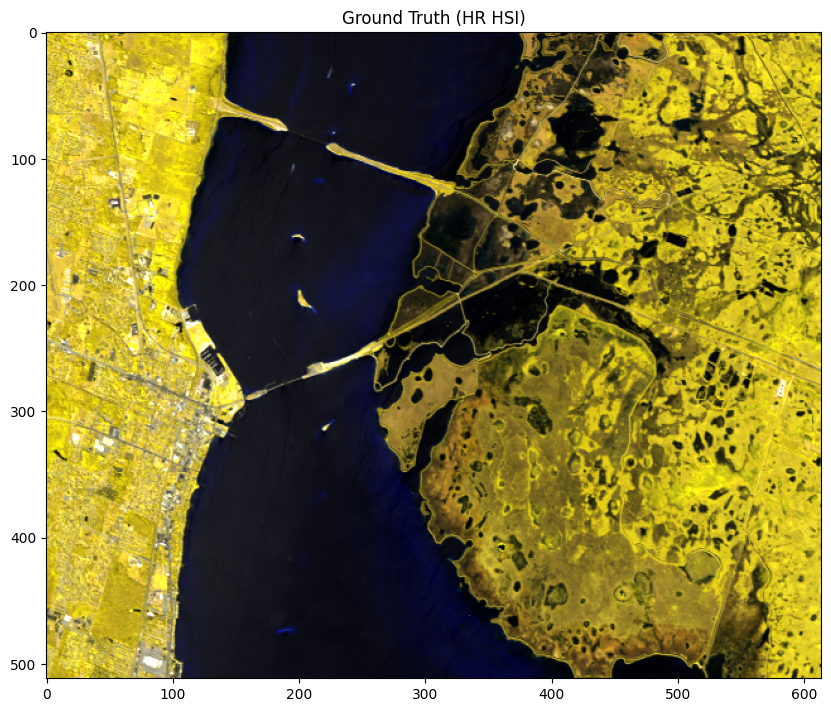

MSI shape:  (512, 614, 1)


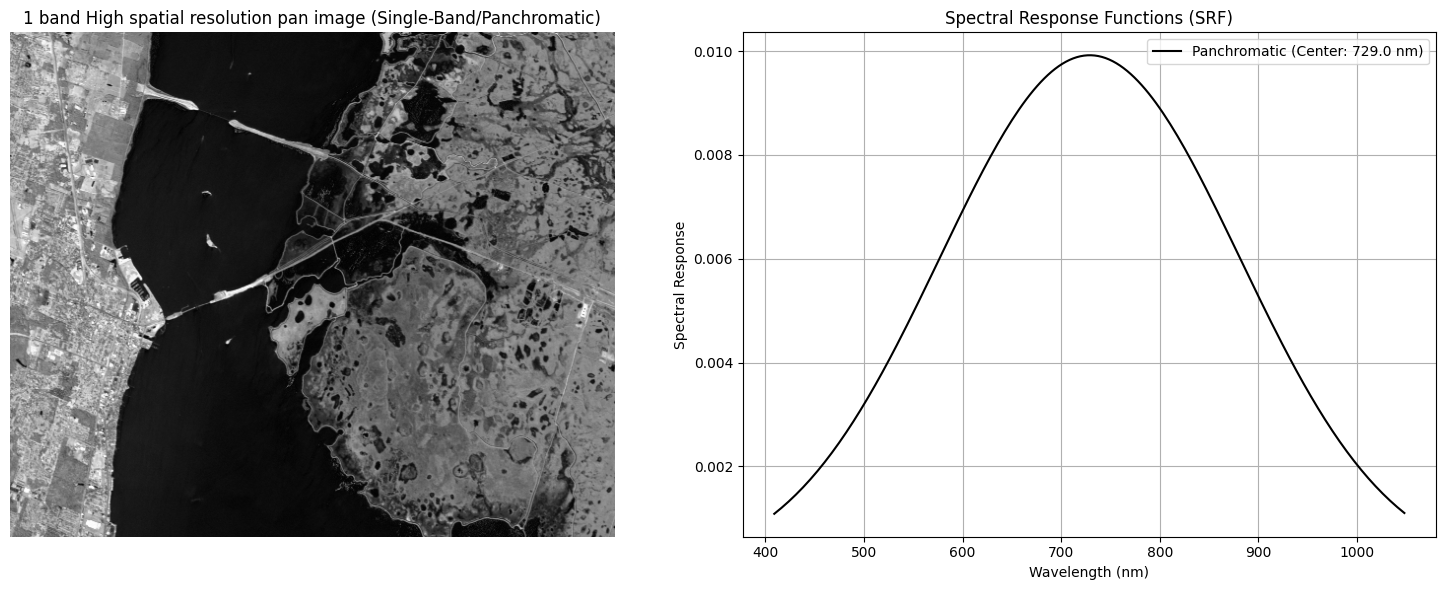

MSI shape:  (512, 614, 3)


MSI shape:  (512, 614, 4)


MSI shape:  (512, 614, 8)


MSI shape:  (512, 614, 16)


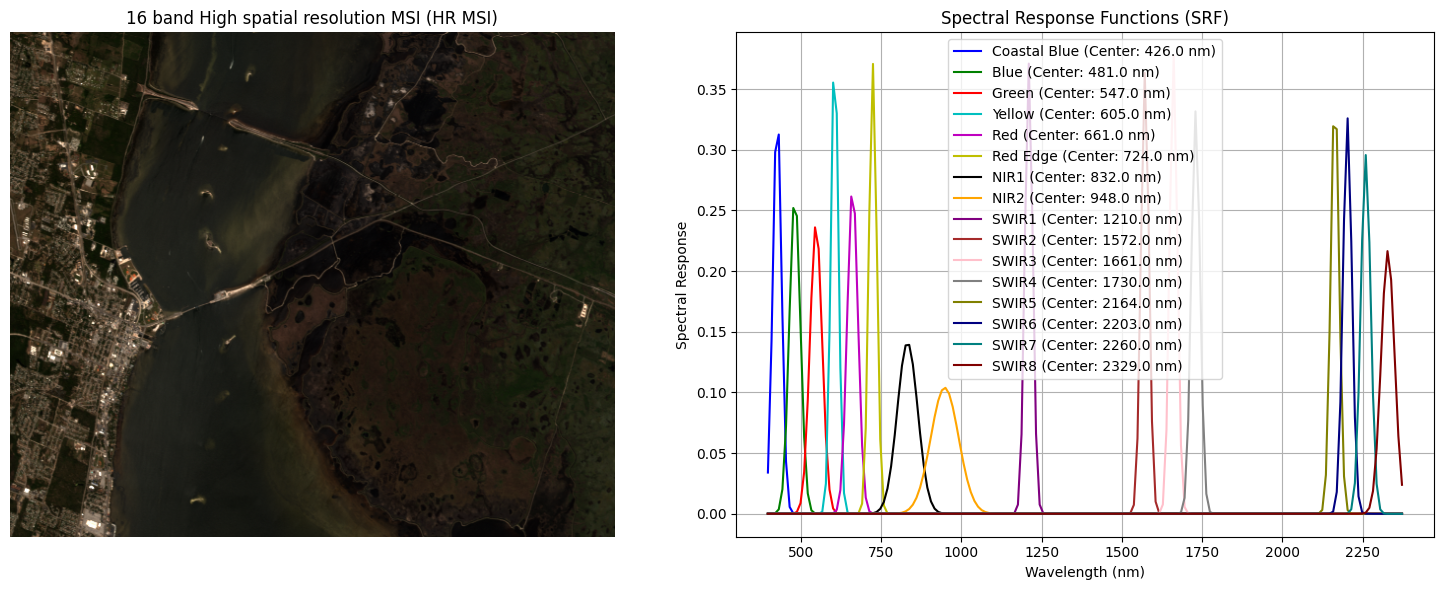

In [9]:
ksc = sio.loadmat(mat_file_path)
ksc_image = ksc['KSC']

# Ground Truth HR HSI (H, W, C)
I_REF = normalize(ksc_image)
print("Ground truth image shape: ", I_REF.shape)
visualize_hsi(I_REF, (70,54,23), "Ground Truth (HR HSI)")

# High Resolution MSI with 1 band
I_MS_1, srf_1, band_specs_1, auto_wavs_1 = spectral_degradation(image=ksc_image, SNR=40, num_bands=1, fwhm_factor=4.2)
print("MSI shape: ", I_MS_1.shape)
plot_multispectral_with_srf(I_MS_1, None, "1 band High spatial resolution pan image", srf_1, auto_wavs_1, band_specs_1)

# High Resolution MSI with 3 bands
I_MS_3, srf_3, band_specs_3, auto_wavs_3 = spectral_degradation(image=ksc_image, SNR=40, num_bands=3, fwhm_factor=4.2)
print("MSI shape: ", I_MS_3.shape)
plot_multispectral_with_srf(I_MS_3, (2,1,0), "3 band High spatial resolution RGB image", srf_3, auto_wavs_3, band_specs_3)

# High Resolution MSI with 4 bands
I_MS_4, srf_4, band_specs_4, auto_wavs_4 = spectral_degradation(image=ksc_image, SNR=40, num_bands=4, fwhm_factor=4.2)
print("MSI shape: ", I_MS_4.shape)
plot_multispectral_with_srf(I_MS_4, (2,1,0), "4 band High spatial resolution MSI (HR MSI)", srf_4, auto_wavs_4, band_specs_4)

# High Resolution MSI with 8 bands
I_MS_8, srf_8, band_specs_8, auto_wavs_8 = spectral_degradation(image=ksc_image, SNR=40, num_bands=8, fwhm_factor=4.2)
print("MSI shape: ", I_MS_8.shape)
plot_multispectral_with_srf(I_MS_8, (4,2,1), "8 band High spatial resolution MSI (HR MSI)", srf_8, auto_wavs_8, band_specs_8)

# High Resolution MSI with 16 bands
I_MS_16, srf_16, band_specs_16, auto_wavs_16 = spectral_degradation(image=ksc_image, SNR=40, num_bands=16, fwhm_factor=4.2)
print("MSI shape: ", I_MS_16.shape)
plot_multispectral_with_srf(I_MS_16, (4,2,1), "16 band High spatial resolution MSI (HR MSI)", srf_16, auto_wavs_16, band_specs_16)

Setting up and visualizing the HSI images with Gaussian PSF

HSI shape with 4x Downsample:  (128, 153, 176)


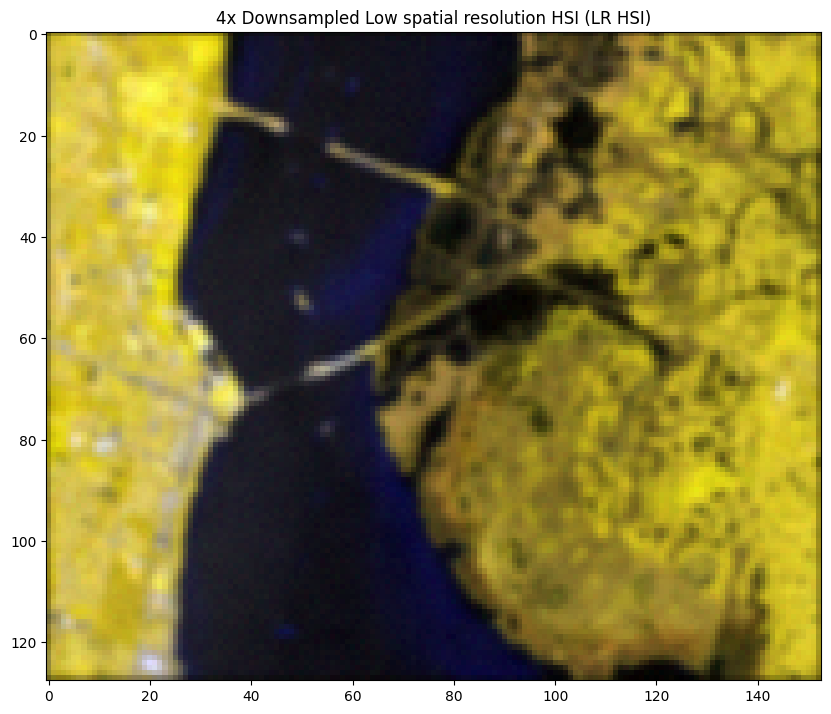

HSI shape with 8x Downsample:  (64, 76, 176)


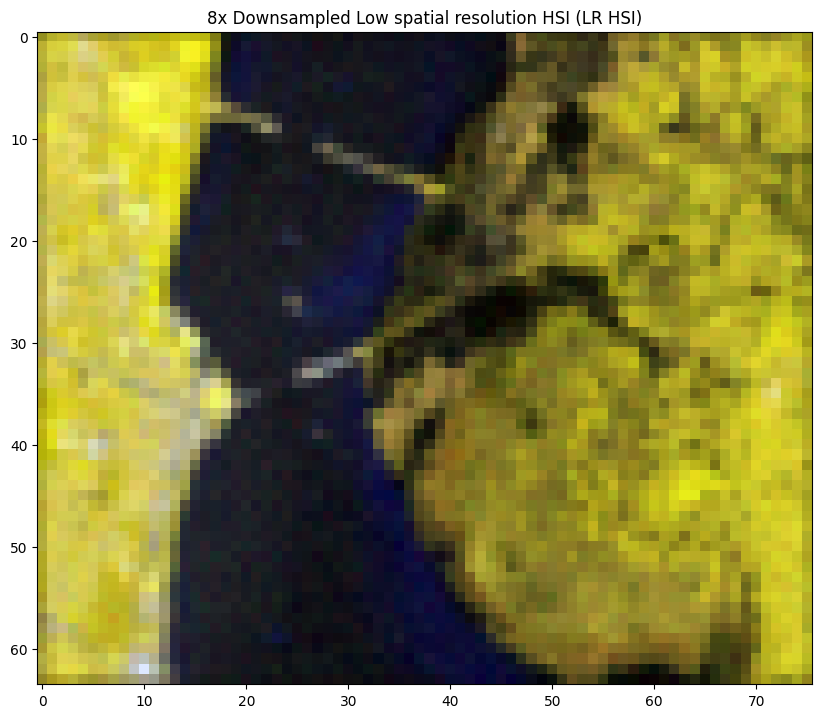

HSI shape with 16x Downsample:  (32, 38, 176)


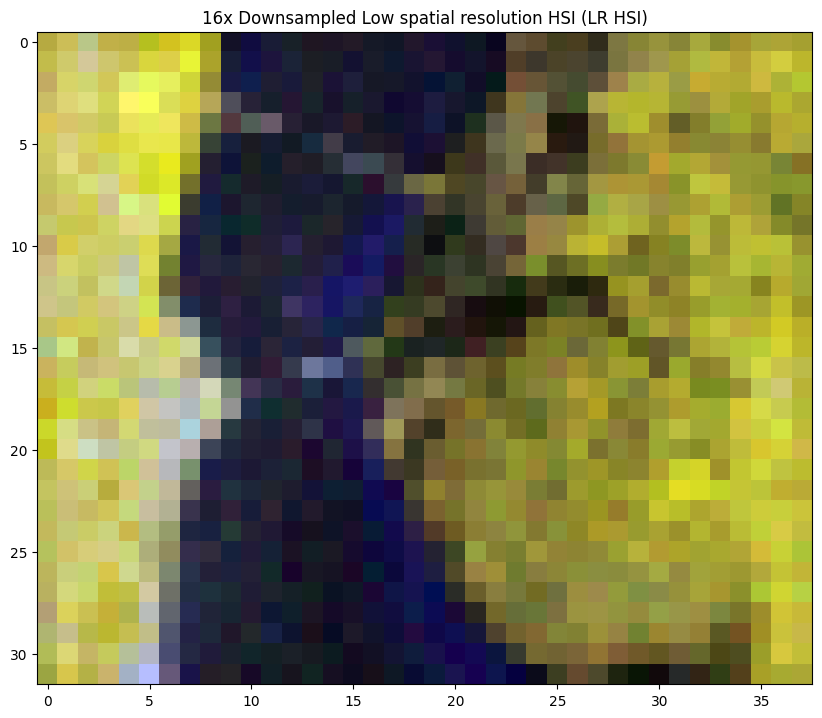

HSI shape with 32x Downsample:  (16, 19, 176)


In [10]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gaus = spatial_degradation(ksc_image, gaus_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gaus.shape)
visualize_hsi(I_HS_4_gaus, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gaus = spatial_degradation(ksc_image, gaus_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gaus.shape)
visualize_hsi(I_HS_8_gaus, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gaus = spatial_degradation(ksc_image, gaus_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gaus.shape)
visualize_hsi(I_HS_16_gaus, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gaus = spatial_degradation(ksc_image, gaus_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gaus.shape)
visualize_hsi(I_HS_32_gaus, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Kolmogorov PSF

HSI shape with 4x Downsample:  (128, 153, 176)


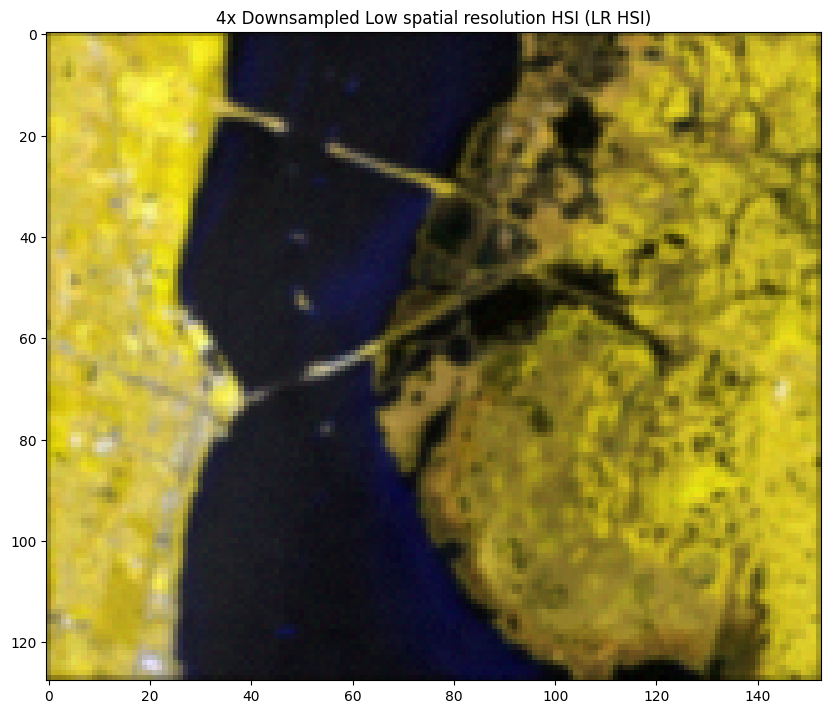

HSI shape with 8x Downsample:  (64, 76, 176)


HSI shape with 16x Downsample:  (32, 38, 176)


HSI shape with 32x Downsample:  (16, 19, 176)


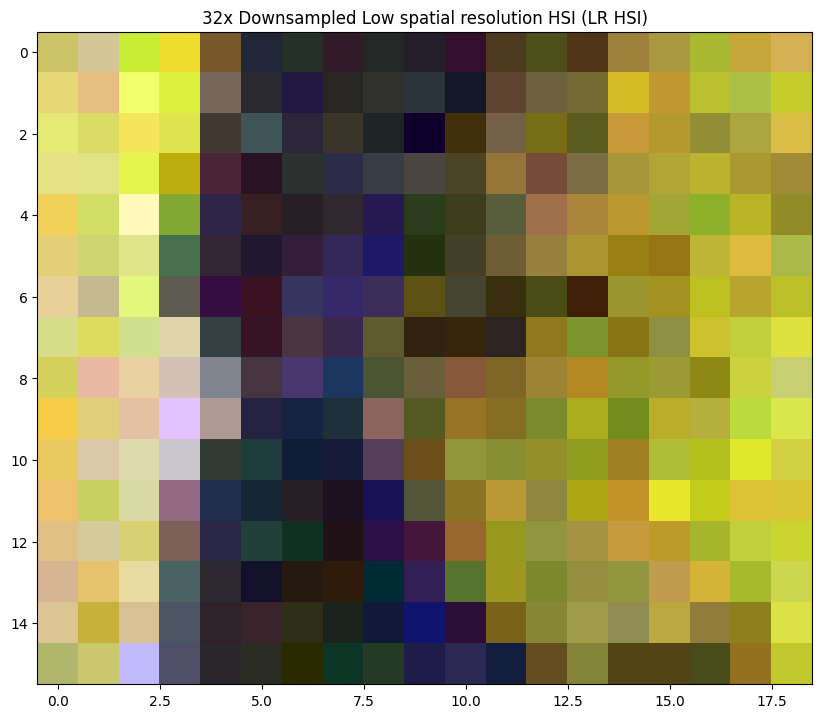

In [11]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_kol = spatial_degradation(ksc_image, kol_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_kol.shape)
visualize_hsi(I_HS_4_kol, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_kol = spatial_degradation(ksc_image, kol_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_kol.shape)
visualize_hsi(I_HS_8_kol, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_kol = spatial_degradation(ksc_image, kol_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_kol.shape)
visualize_hsi(I_HS_16_kol, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_kol = spatial_degradation(ksc_image, kol_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_kol.shape)
visualize_hsi(I_HS_32_kol, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Airy PSF

HSI shape with 4x Downsample:  (128, 153, 176)


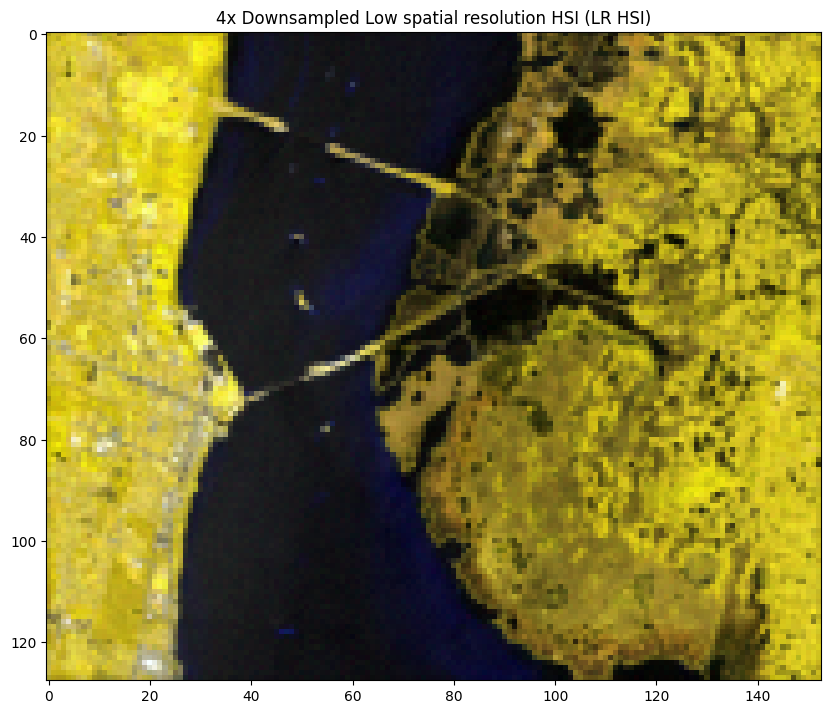

HSI shape with 8x Downsample:  (64, 76, 176)


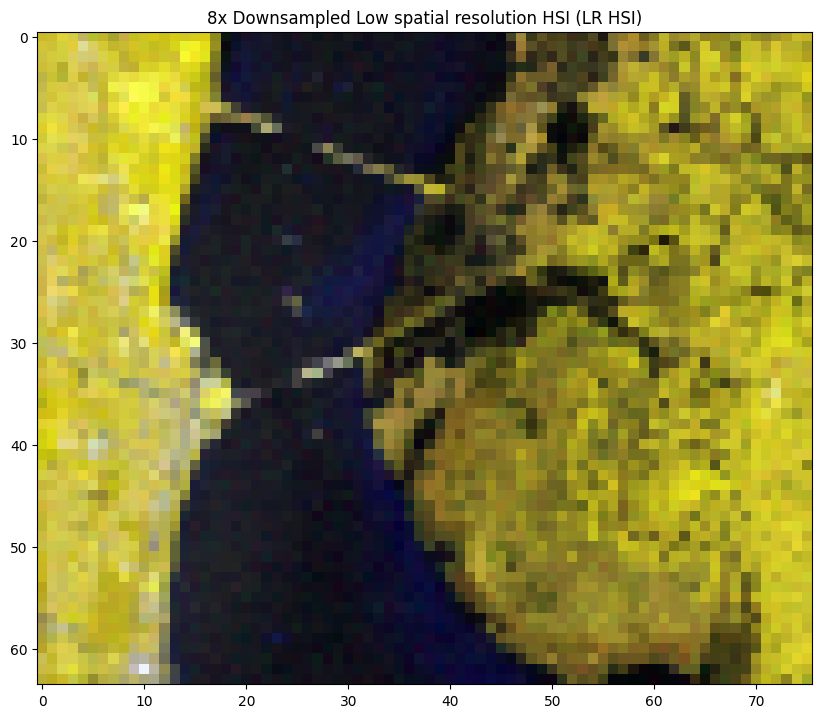

HSI shape with 16x Downsample:  (32, 38, 176)


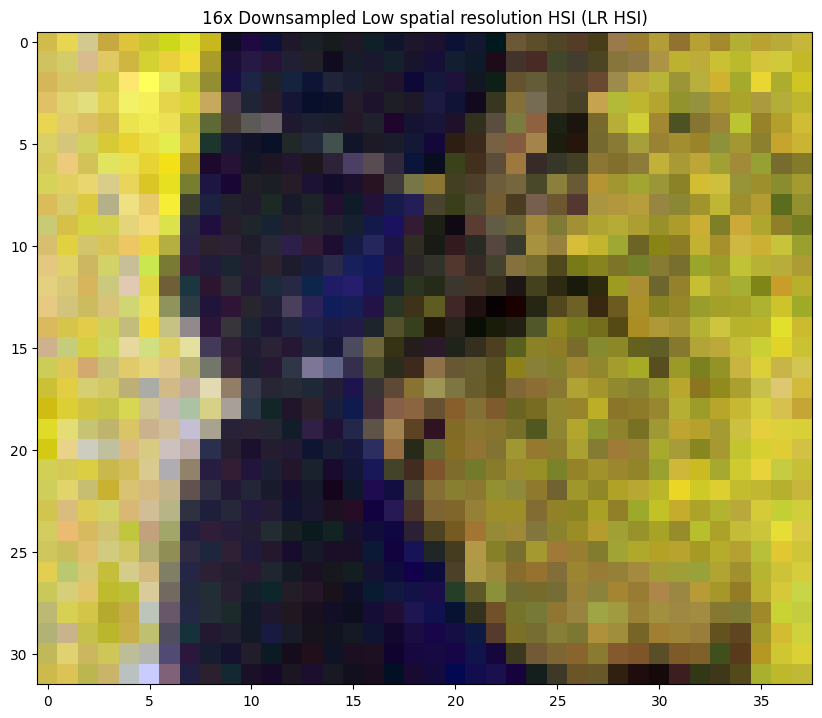

HSI shape with 32x Downsample:  (16, 19, 176)


In [12]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_air = spatial_degradation(ksc_image, air_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_air.shape)
visualize_hsi(I_HS_4_air, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_air = spatial_degradation(ksc_image, air_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_air.shape)
visualize_hsi(I_HS_8_air, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_air = spatial_degradation(ksc_image, air_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_air.shape)
visualize_hsi(I_HS_16_air, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_air = spatial_degradation(ksc_image, air_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_air.shape)
visualize_hsi(I_HS_32_air, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Moffat PSF

HSI shape with 4x Downsample:  (128, 153, 176)


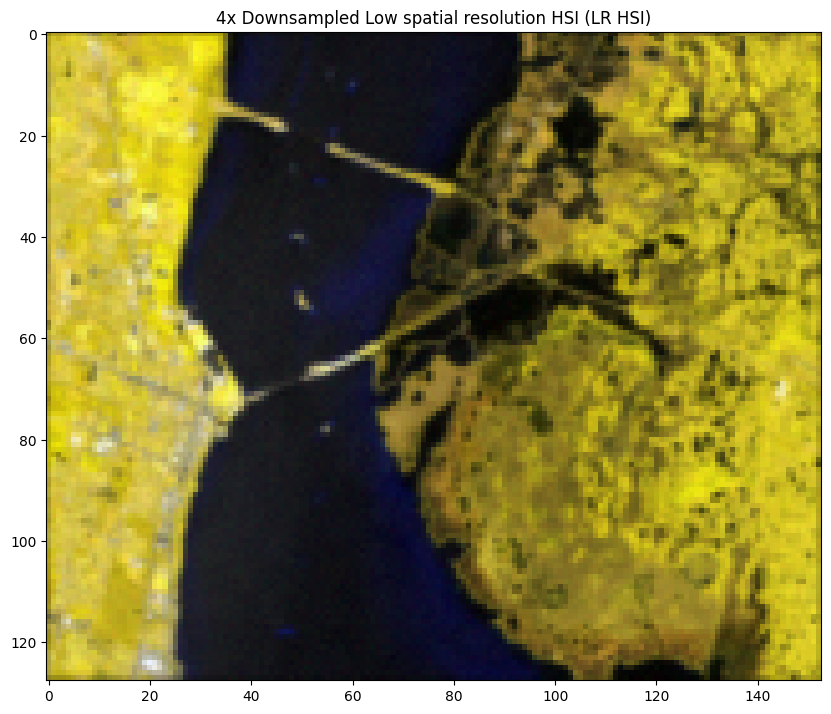

HSI shape with 8x Downsample:  (64, 76, 176)


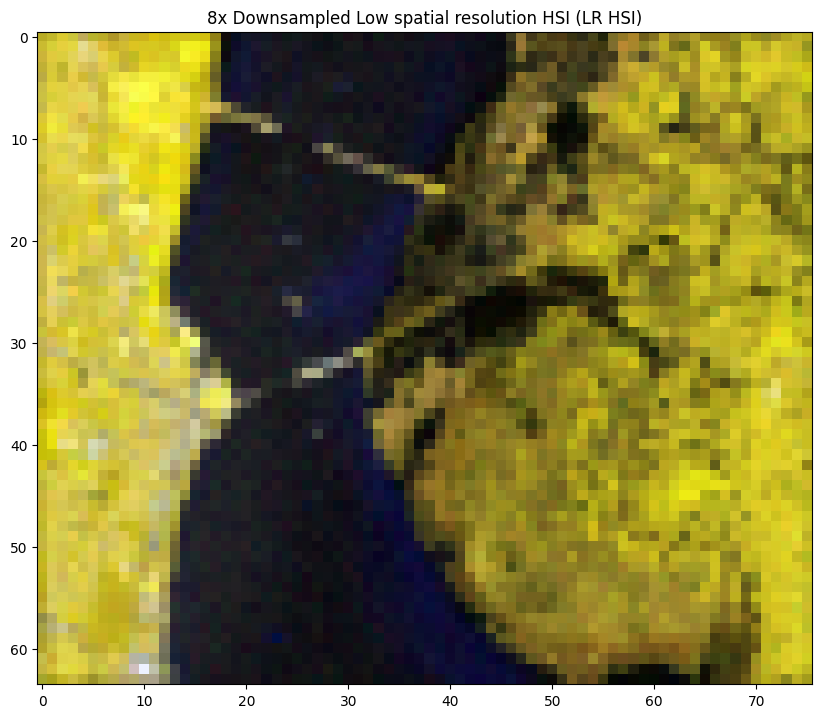

HSI shape with 16x Downsample:  (32, 38, 176)


HSI shape with 32x Downsample:  (16, 19, 176)


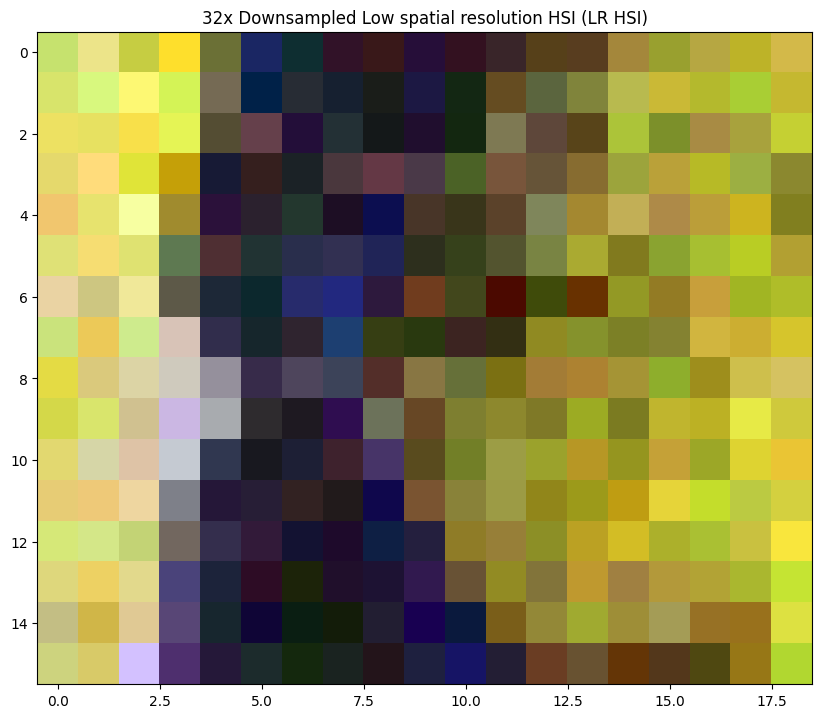

In [13]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_mof = spatial_degradation(ksc_image, mof_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_mof.shape)
visualize_hsi(I_HS_4_mof, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_mof = spatial_degradation(ksc_image, mof_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_mof.shape)
visualize_hsi(I_HS_8_mof, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_mof = spatial_degradation(ksc_image, mof_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_mof.shape)
visualize_hsi(I_HS_16_mof, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_mof = spatial_degradation(ksc_image, mof_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_mof.shape)
visualize_hsi(I_HS_32_mof, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Sinc PSF

HSI shape with 4x Downsample:  (128, 153, 176)


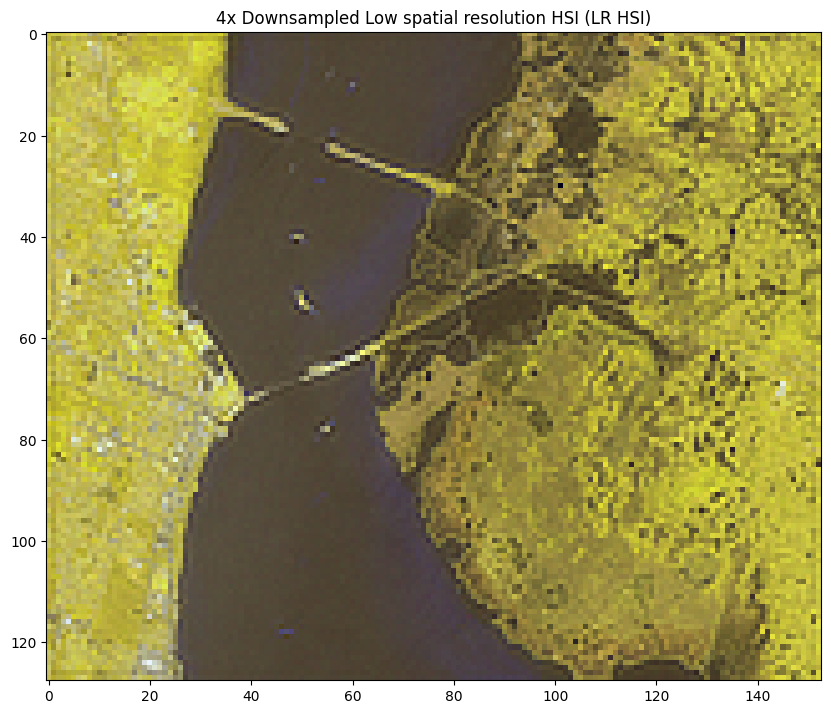

HSI shape with 8x Downsample:  (64, 76, 176)


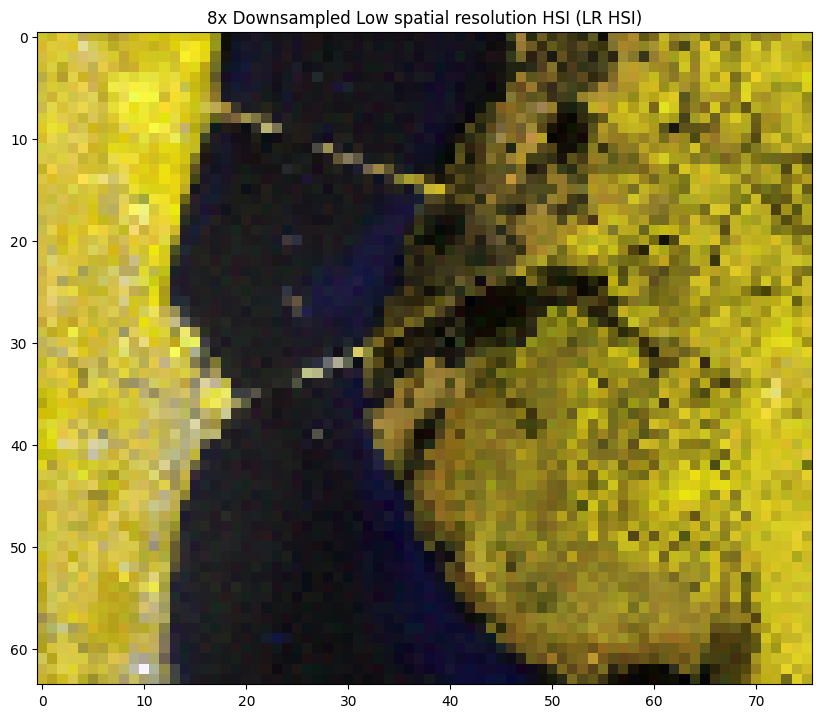

HSI shape with 16x Downsample:  (32, 38, 176)


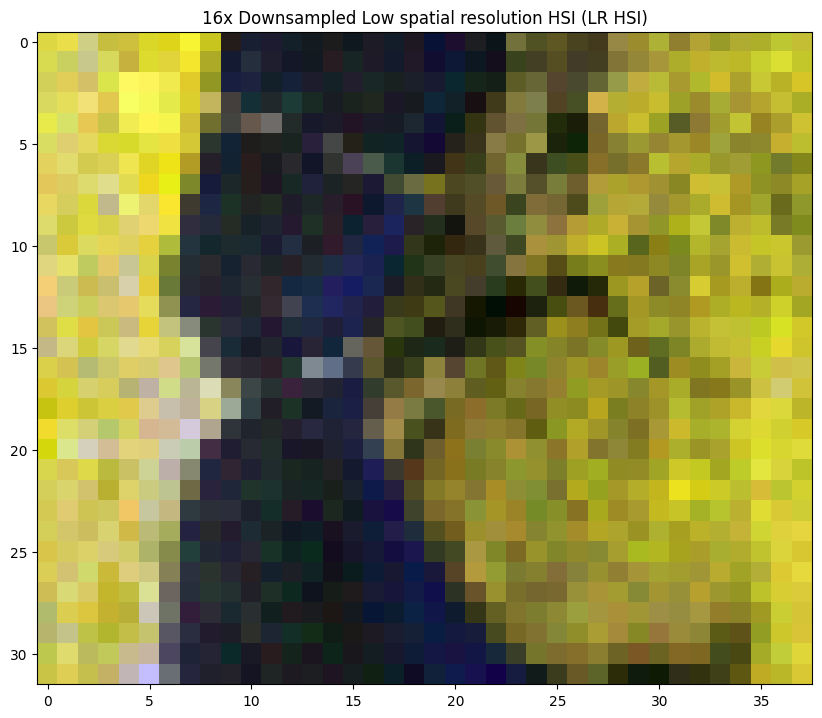

HSI shape with 32x Downsample:  (16, 19, 176)


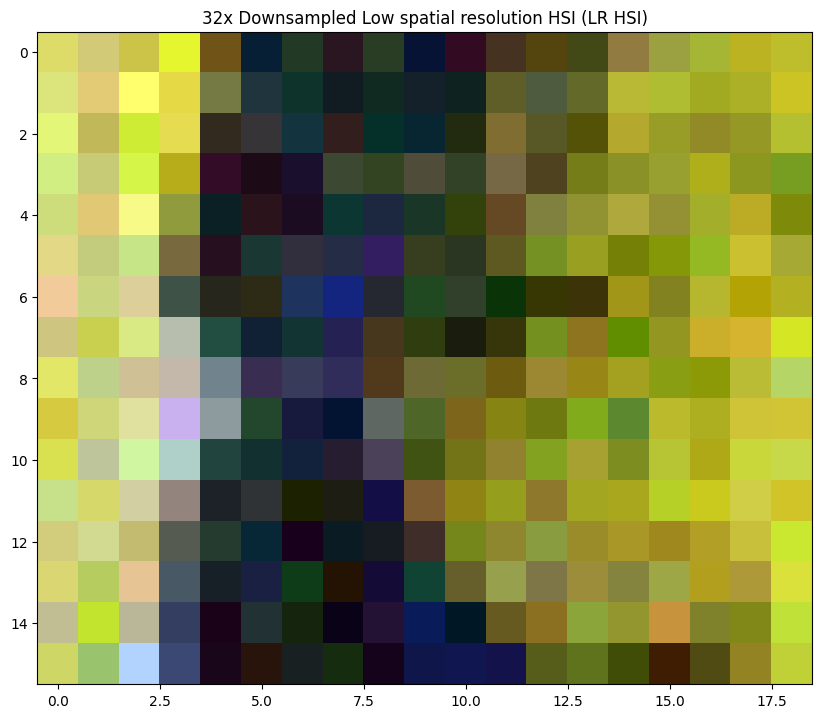

In [14]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_sinc = spatial_degradation(ksc_image, sinc_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_sinc.shape)
visualize_hsi(I_HS_4_sinc, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_sinc = spatial_degradation(ksc_image, sinc_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_sinc.shape)
visualize_hsi(I_HS_8_sinc, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_sinc = spatial_degradation(ksc_image, sinc_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_sinc.shape)
visualize_hsi(I_HS_16_sinc, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_sinc = spatial_degradation(ksc_image, sinc_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_sinc.shape)
visualize_hsi(I_HS_32_sinc, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Lorentzian Squared PSF

HSI shape with 4x Downsample:  (128, 153, 176)


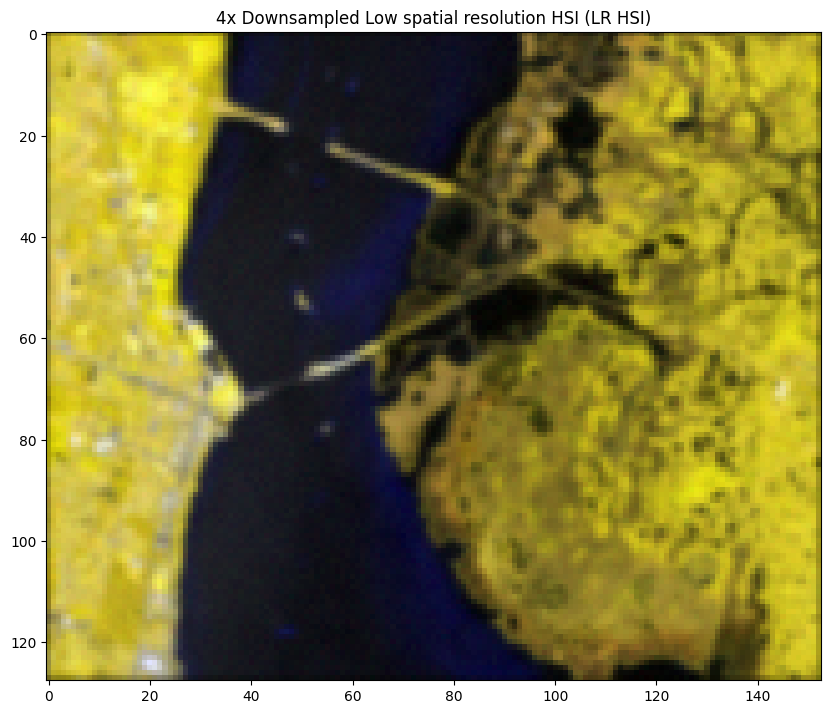

HSI shape with 8x Downsample:  (64, 76, 176)


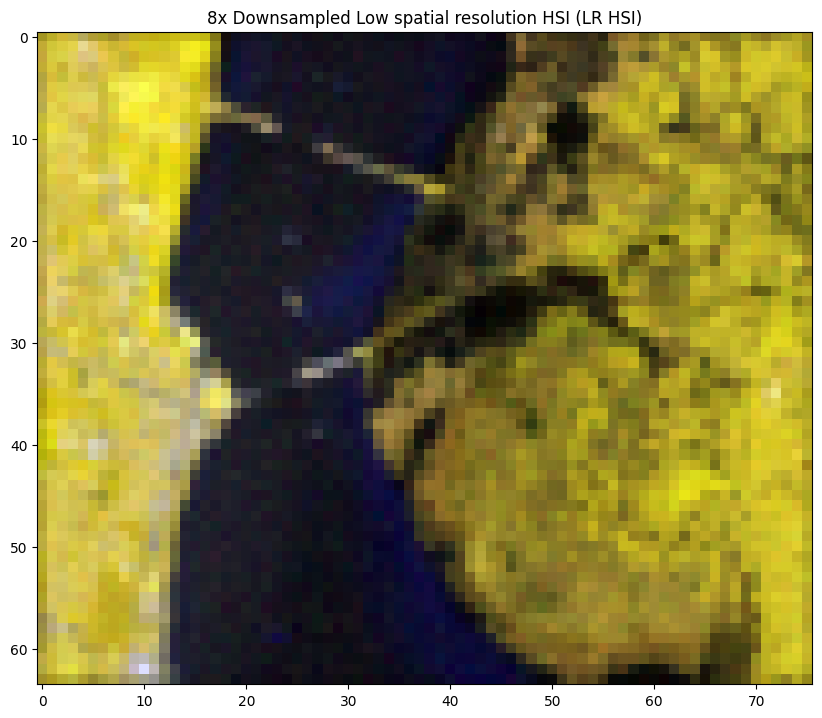

HSI shape with 16x Downsample:  (32, 38, 176)


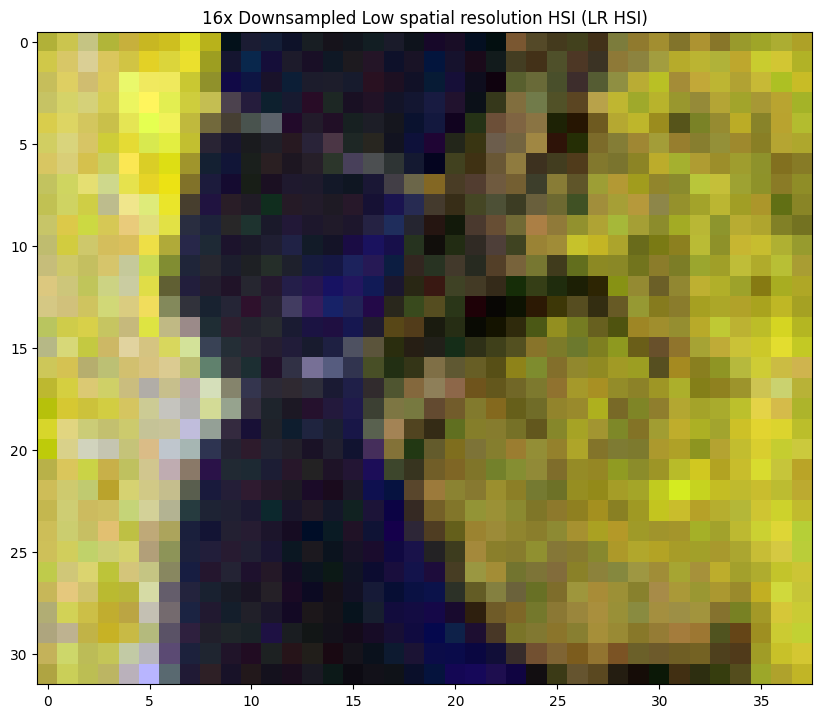

HSI shape with 32x Downsample:  (16, 19, 176)


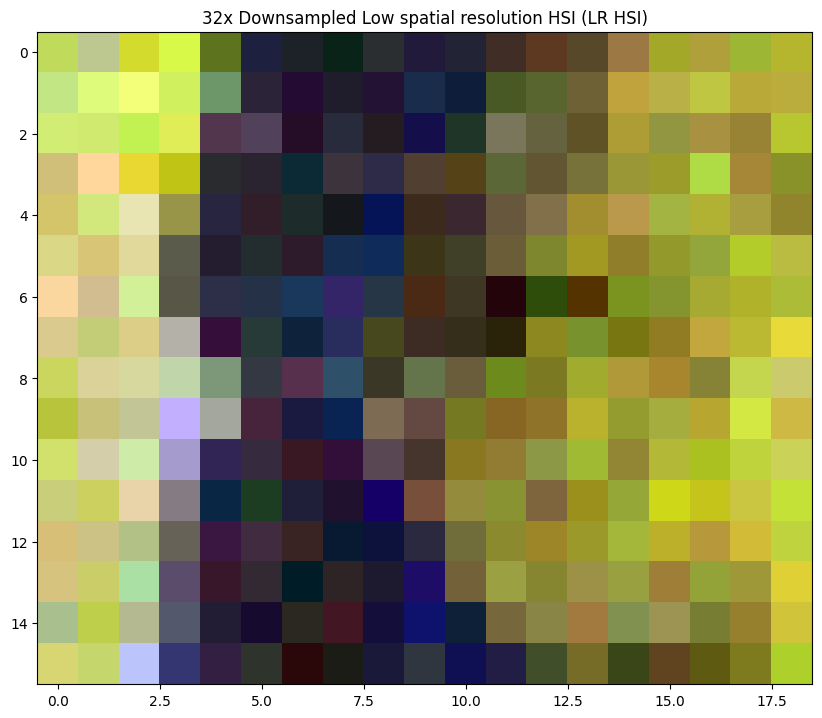

In [15]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_lor_sq = spatial_degradation(ksc_image, lor_sq_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_lor_sq.shape)
visualize_hsi(I_HS_4_lor_sq, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_lor_sq = spatial_degradation(ksc_image, lor_sq_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_lor_sq.shape)
visualize_hsi(I_HS_8_lor_sq, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_lor_sq = spatial_degradation(ksc_image, lor_sq_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_lor_sq.shape)
visualize_hsi(I_HS_16_lor_sq, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_lor_sq = spatial_degradation(ksc_image, lor_sq_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_lor_sq.shape)
visualize_hsi(I_HS_32_lor_sq, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Hermite PSF

HSI shape with 4x Downsample:  (128, 153, 176)


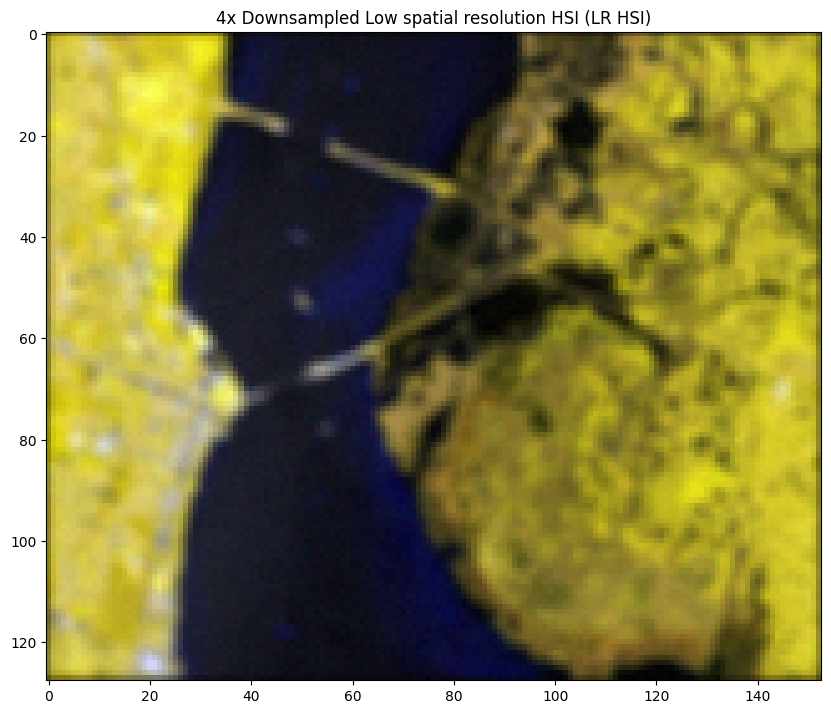

HSI shape with 8x Downsample:  (64, 76, 176)


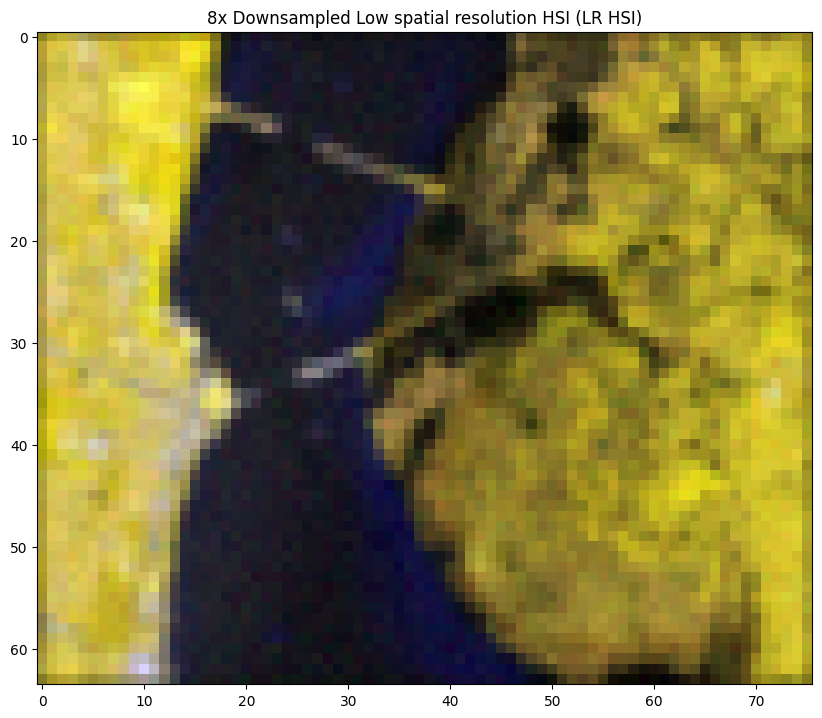

HSI shape with 16x Downsample:  (32, 38, 176)


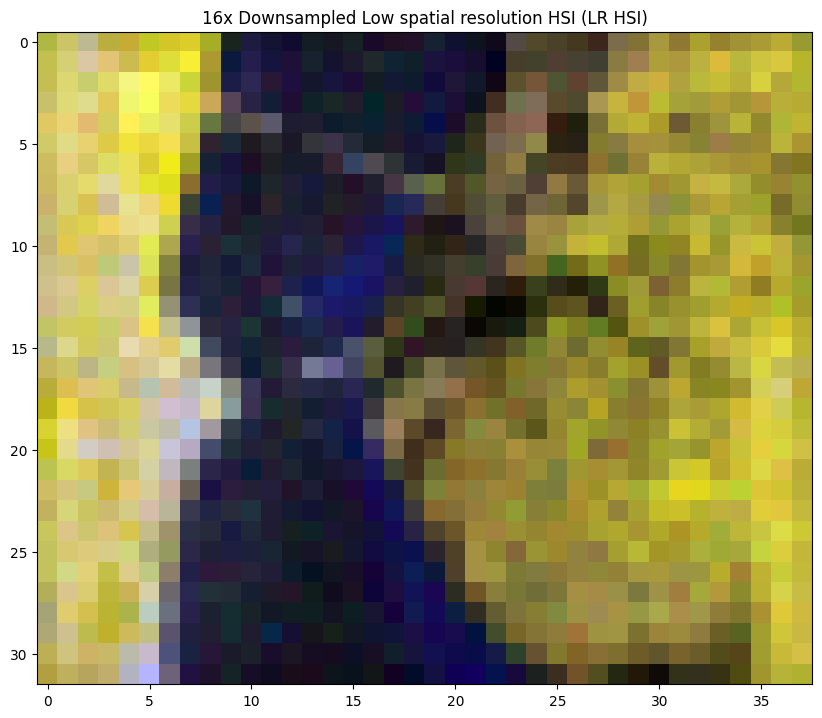

HSI shape with 32x Downsample:  (16, 19, 176)


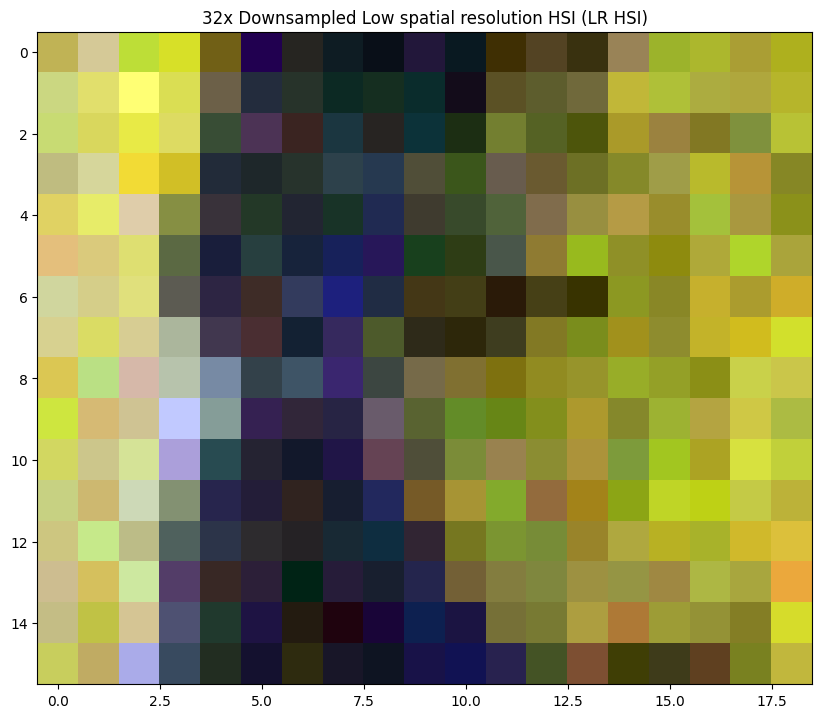

In [16]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_her = spatial_degradation(ksc_image, her_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_her.shape)
visualize_hsi(I_HS_4_her, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_her = spatial_degradation(ksc_image, her_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_her.shape)
visualize_hsi(I_HS_8_her, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_her = spatial_degradation(ksc_image, her_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_her.shape)
visualize_hsi(I_HS_16_her, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_her = spatial_degradation(ksc_image, her_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_her.shape)
visualize_hsi(I_HS_32_her, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Parabolic PSF

HSI shape with 4x Downsample:  (128, 153, 176)


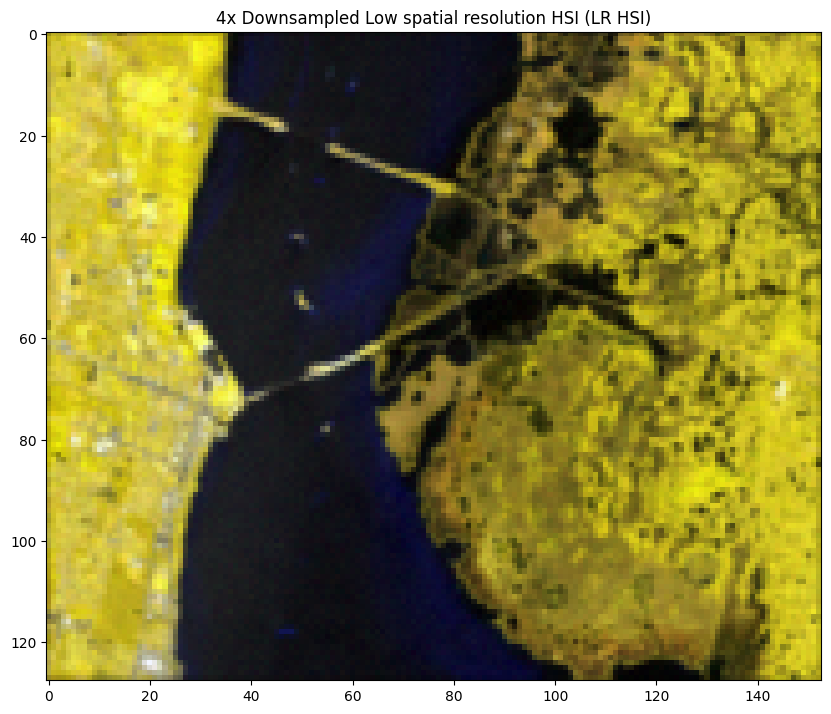

HSI shape with 8x Downsample:  (64, 76, 176)


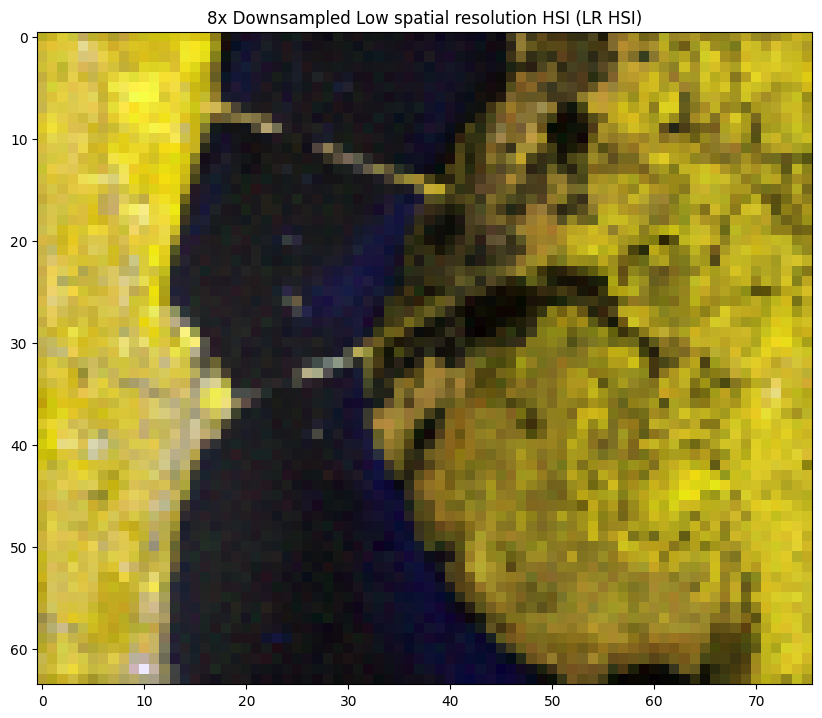

HSI shape with 16x Downsample:  (32, 38, 176)


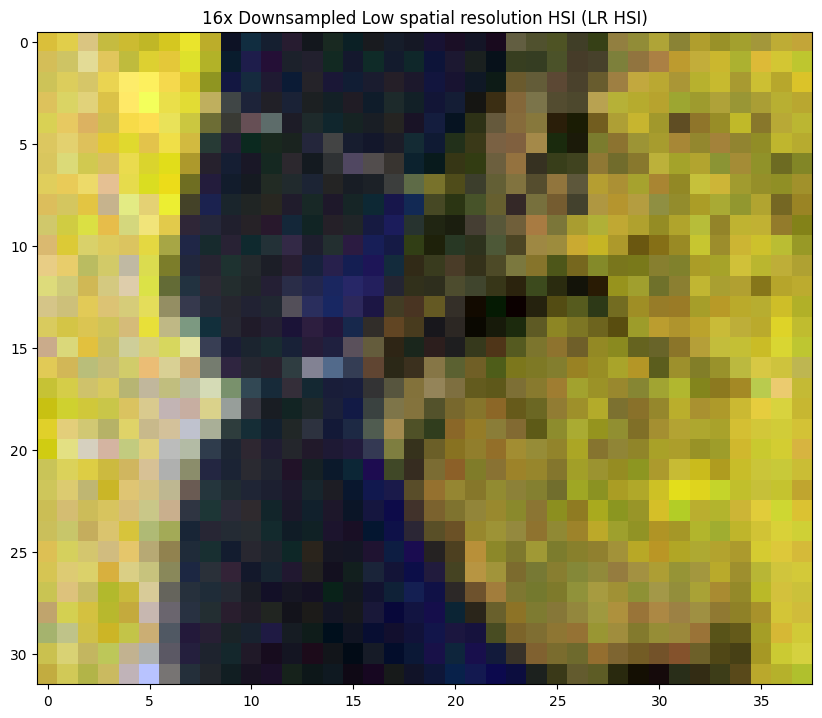

HSI shape with 32x Downsample:  (16, 19, 176)


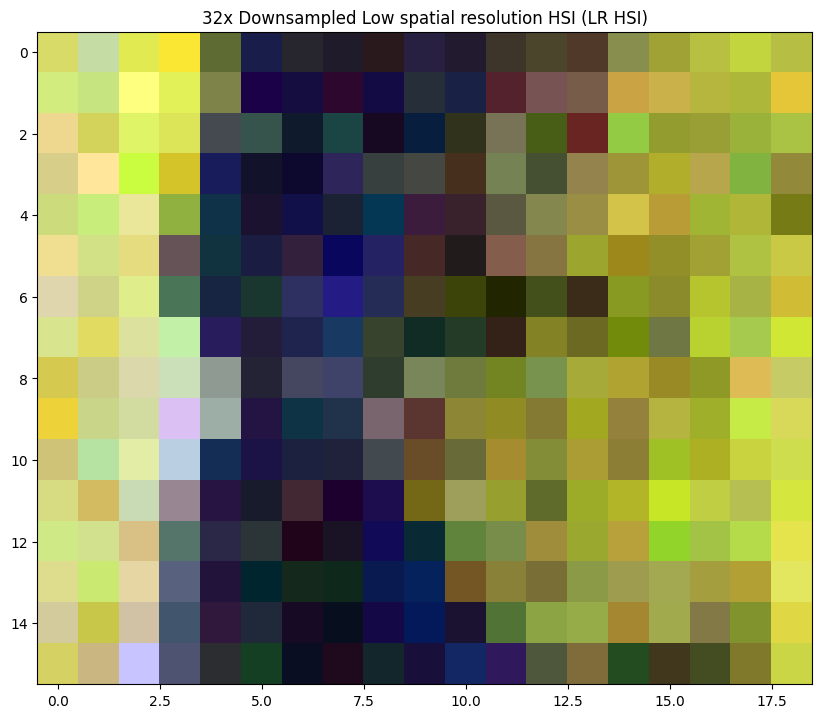

In [17]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_par = spatial_degradation(ksc_image, par_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_par.shape)
visualize_hsi(I_HS_4_par, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_par = spatial_degradation(ksc_image, par_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_par.shape)
visualize_hsi(I_HS_8_par, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_par = spatial_degradation(ksc_image, par_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_par.shape)
visualize_hsi(I_HS_16_par, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_par = spatial_degradation(ksc_image, par_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_par.shape)
visualize_hsi(I_HS_32_par, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Gabor PSF

HSI shape with 4x Downsample:  (128, 153, 176)


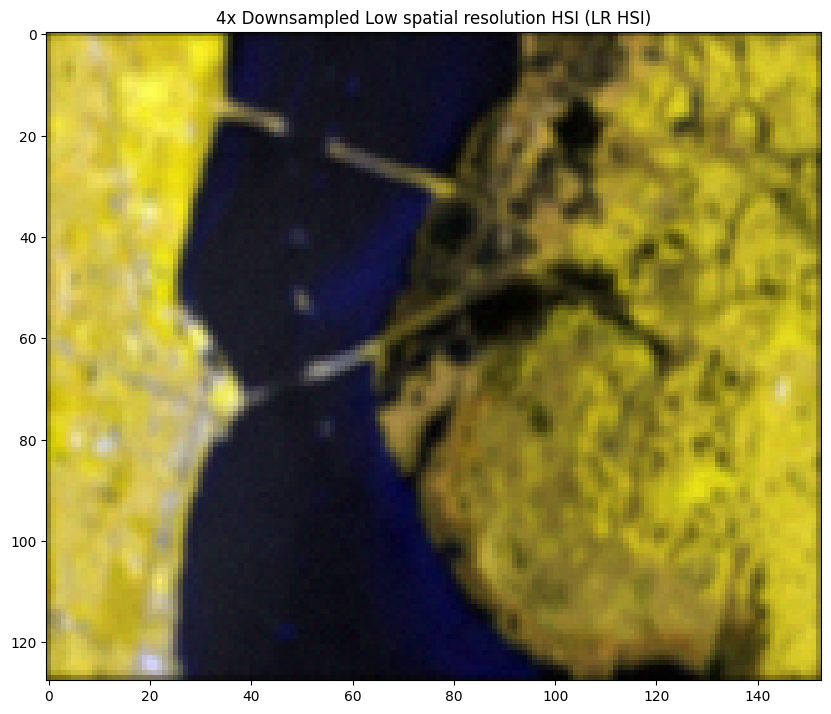

HSI shape with 8x Downsample:  (64, 76, 176)


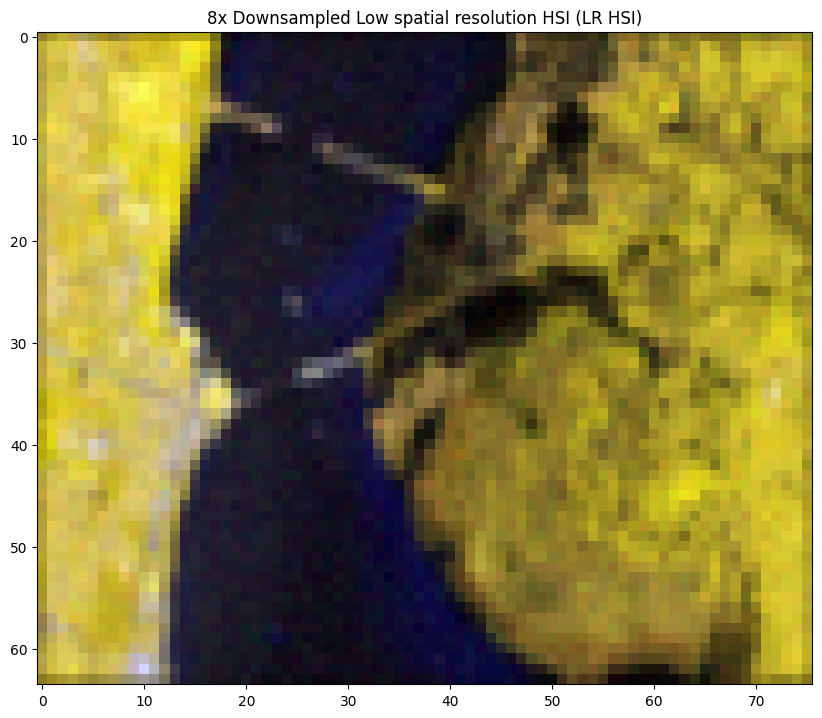

HSI shape with 16x Downsample:  (32, 38, 176)


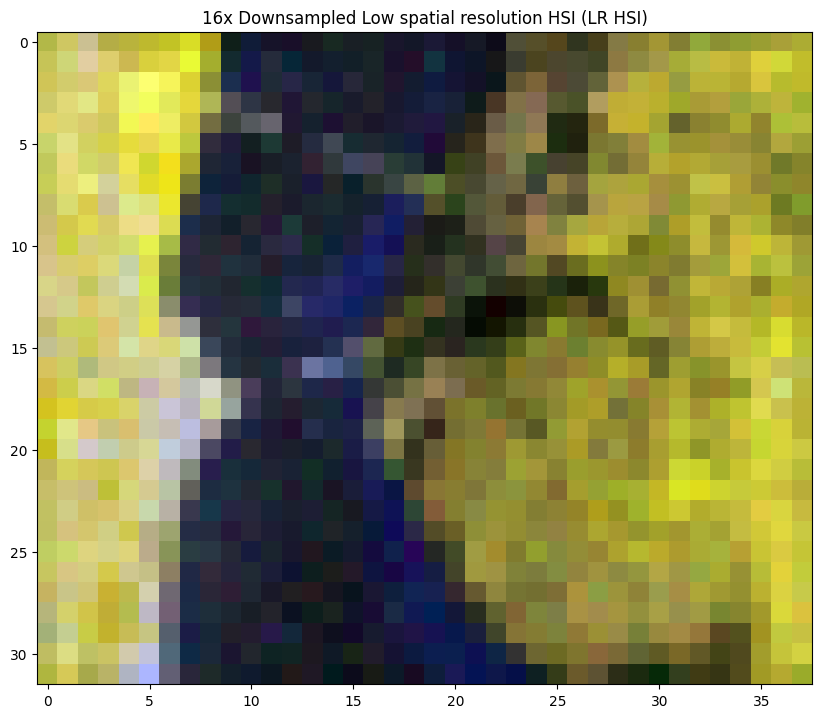

HSI shape with 32x Downsample:  (16, 19, 176)


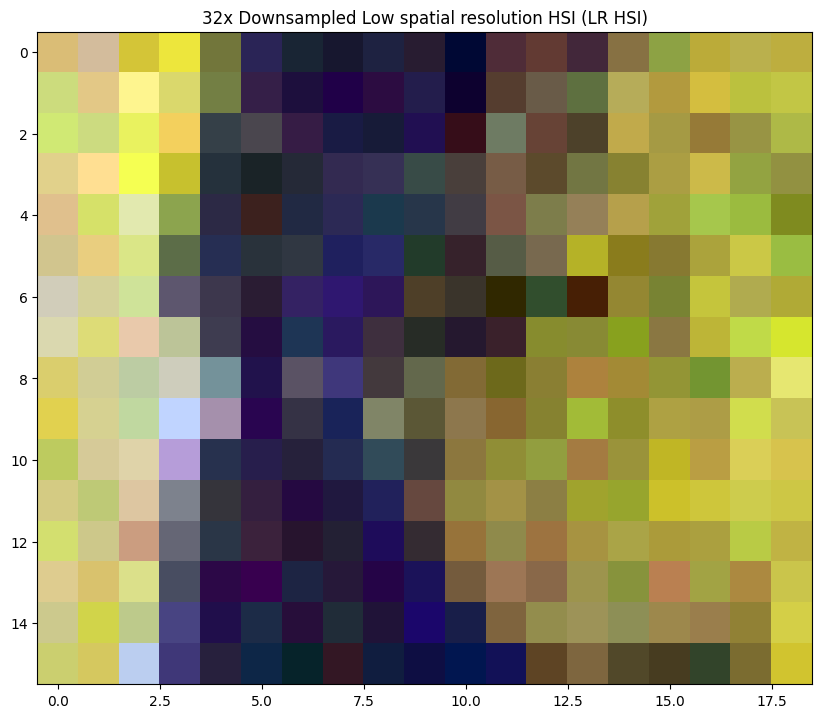

In [18]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_gab = spatial_degradation(ksc_image, gab_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_gab.shape)
visualize_hsi(I_HS_4_gab, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_gab = spatial_degradation(ksc_image, gab_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_gab.shape)
visualize_hsi(I_HS_8_gab, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_gab = spatial_degradation(ksc_image, gab_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_gab.shape)
visualize_hsi(I_HS_16_gab, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_gab = spatial_degradation(ksc_image, gab_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_gab.shape)
visualize_hsi(I_HS_32_gab, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

Setting up and visualizing the HSI images with Delta PSF

HSI shape with 4x Downsample:  (128, 153, 176)


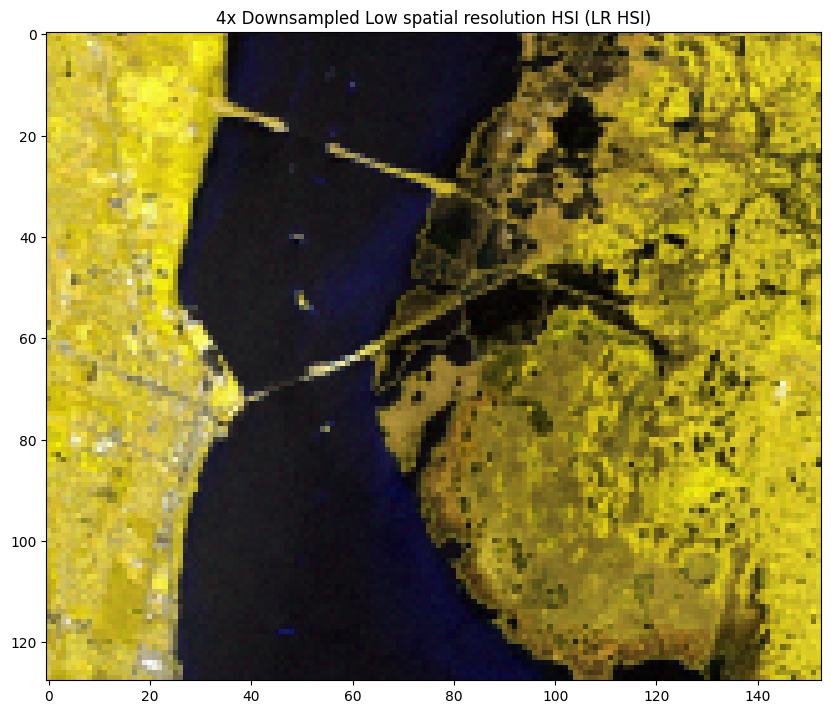

HSI shape with 8x Downsample:  (64, 76, 176)


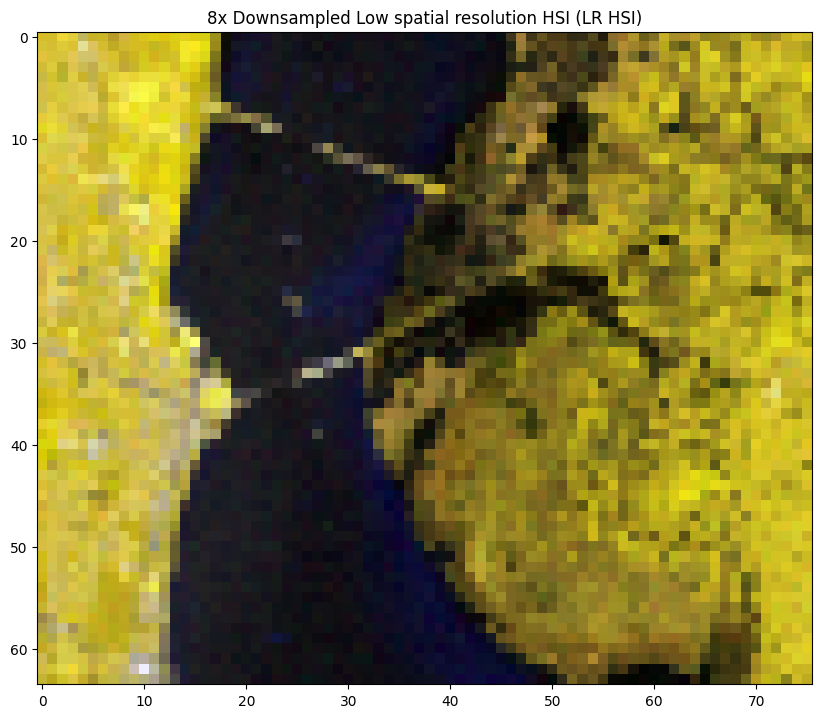

HSI shape with 16x Downsample:  (32, 38, 176)


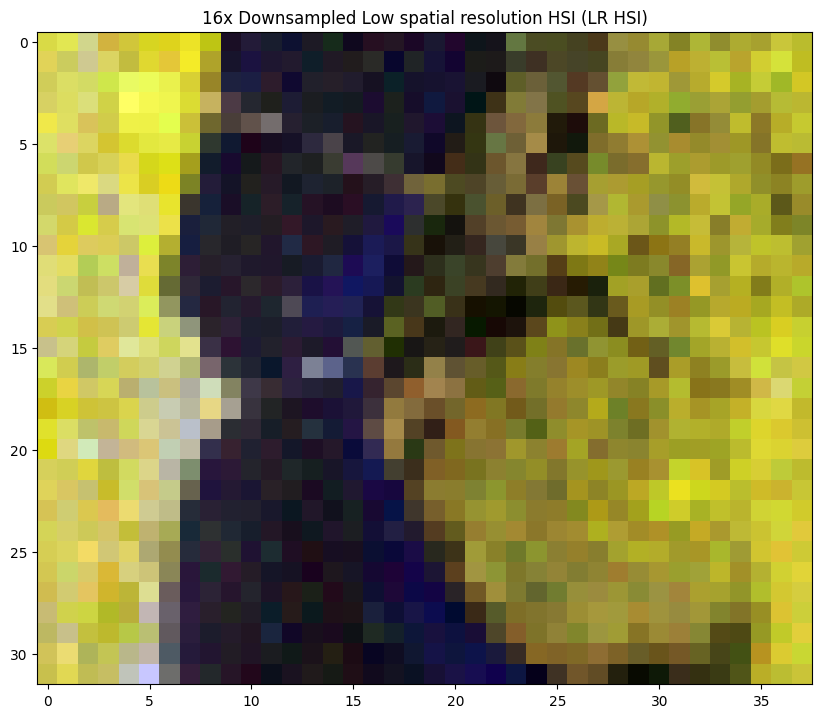

HSI shape with 32x Downsample:  (16, 19, 176)


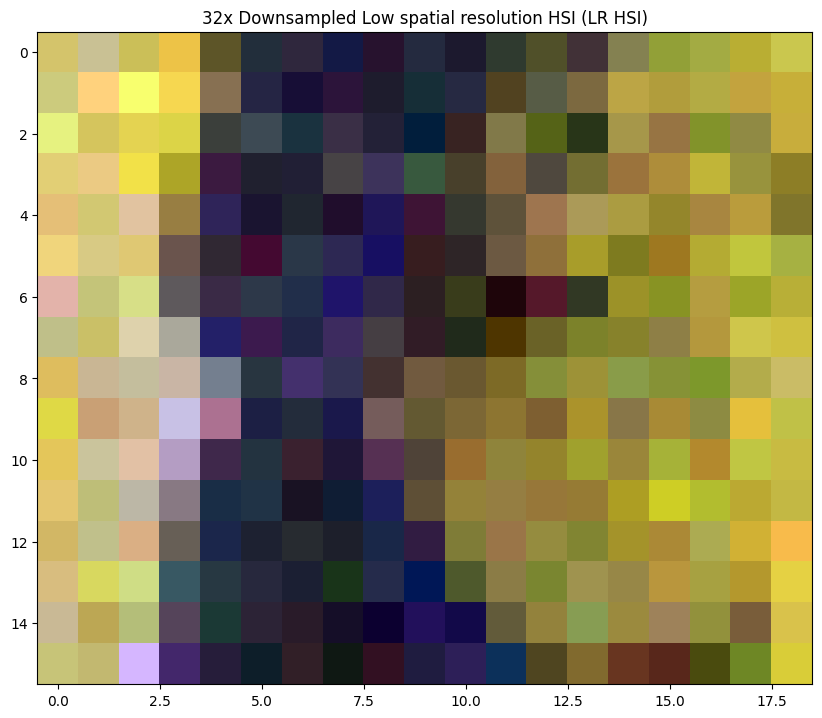

In [19]:
# Low Resolution HSI with 4x downsampling (H/4, W/4, C)
I_HS_4_delta = spatial_degradation(ksc_image, delta_psf, 4, 35)
print("HSI shape with 4x Downsample: ", I_HS_4_delta.shape)
visualize_hsi(I_HS_4_delta, (70,54,23), "4x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 8x downsampling (H/8, W/8, C)
I_HS_8_delta = spatial_degradation(ksc_image, delta_psf, 8, 30)
print("HSI shape with 8x Downsample: ", I_HS_8_delta.shape)
visualize_hsi(I_HS_8_delta, (70,54,23), "8x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 16x downsampling (H/16, W/16, C)
I_HS_16_delta = spatial_degradation(ksc_image, delta_psf, 16, 25)
print("HSI shape with 16x Downsample: ", I_HS_16_delta.shape)
visualize_hsi(I_HS_16_delta, (70,54,23), "16x Downsampled Low spatial resolution HSI (LR HSI)")

# Low Resolution HSI with 32x downsampling (H/32, W/32, C)
I_HS_32_delta = spatial_degradation(ksc_image, delta_psf, 32, 20)
print("HSI shape with 32x Downsample: ", I_HS_32_delta.shape)
visualize_hsi(I_HS_32_delta, (70,54,23), "32x Downsampled Low spatial resolution HSI (LR HSI)")

SSSR: Self-supervised spectral super-resolution for a fast hyperspectral and multispectral image fusion implementation from their GitHub

In [20]:
def apply_psf(channel, psf):
    """
    Convolve a single channel 2D image with PSF using 'same' padding.

    Parameters:
    -----------
    channel : np.ndarray
        Shape (height, width).
    psf : np.ndarray
        Shape (kernel_height, kernel_width).

    Returns:
    --------
    blurred_channel : np.ndarray
        Same shape as input channel (height, width).
    """
    return convolve2d(channel, psf, mode='same')

def numpy_to_tf(np_array):
    
    """
    Converts a numpy array into a tensorflow tensor.
    """
    
    tf_tensor = tf.constant(np_array, dtype=tf.float32)
    return tf_tensor

def tf_to_numpy(tf_tensor):
    
    """
    Converts a tensorflow tensor into a numpy array.
    """
    
    np_array = tf_tensor.numpy()
    return np_array

In [21]:
def get_gpu_memory_mb():
    """Returns current GPU memory usage (in MB) for GPU:0 using TensorFlow."""
    mem_info = tf.config.experimental.get_memory_info('GPU:0')
    return mem_info['current'] / (1024 ** 2)  # bytes → MB

def infer_and_analyze_model_performance_tf(model, sample_inputs):
    """
    Analyzes model complexity: FLOPs, parameters, inference time, and GPU memory usage.
    
    Parameters:
    - model (tf.keras.Model): The model to evaluate.
    - sample_inputs (list of tf.Tensor): List of input tensors matching the model's expected input.
    """
    # 1) Convert sample_inputs into a concrete function
    sample_input = sample_inputs[:1]  # Shape (1, C_msi)

    # Properly trace the model using a callable
    @tf.function
    def model_fn(msi):
        return model(msi)

    concrete_func = model_fn.get_concrete_function(sample_input)

    # 2) Freeze the graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # 3) Compute FLOPs
    try:
        original_stdout = sys.stdout
        sys.stdout = iot.StringIO()

        with tf.Graph().as_default() as graph:
            tf.compat.v1.import_graph_def(graph_def, name="")
            run_meta = tf.compat.v1.RunMetadata()
            opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            opts["output"] = "none"
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                options=opts
            ).total_float_ops
    finally:
        sys.stdout = original_stdout

    # 4) Count parameters and record starting GPU memory
    num_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
    start_mem = get_gpu_memory_mb()

    # 5) Time inference
    start = time.perf_counter()
    SR_image = model(sample_inputs)
    end = time.perf_counter()
    inference_time = end - start

    # 6) GPU memory
    end_mem = get_gpu_memory_mb()
    mem_used = end_mem - start_mem

    # 7) Print results
    print(f"Parameters:      {num_params:,}")
    print(f"FLOPs:           {flops:,}")
    print(f"GPU Memory:      {mem_used:.2f} MB")
    print(f"Inference time:  {inference_time:.4f} sec")

    return SR_image

In [22]:
# ----------------------- Custom PReLU -----------------------
class PReLU(Layer):
    def __init__(self, alpha_initializer=tf.constant_initializer(0.25), **kwargs):
        super(PReLU, self).__init__(**kwargs)
        self.alpha_initializer = tf.keras.initializers.get(alpha_initializer)
    def build(self, input_shape):
        self.alpha = self.add_weight(shape=(input_shape[-1],),
                                     initializer=self.alpha_initializer,
                                     name='alpha',
                                     dtype=tf.float32)
        super(PReLU, self).build(input_shape)
    def call(self, inputs):
        return tf.maximum(0.0, inputs) + self.alpha * tf.minimum(0.0, inputs)

In [23]:
def prepare_hsi_msi_data(HR_MSI, LR_HSI, psf, scale):
    """
    Prepares mrdata and lrdata exactly like the original framework.

    Parameters:
    -----------
    HR_MSI : np.ndarray
        High-resolution multispectral image (H, W, Cₘ).
    LR_HSI : np.ndarray
        Low-resolution hyperspectral image (H/s, W/s, Cₕ).
    psf : np.ndarray
        Point Spread Function kernel (k, k).
    scale : int
        Downsampling factor.

    Returns:
    --------
    mrdata : np.ndarray
        Flattened MSI data (N, Cₘ).
    lrdata : np.ndarray
        Flattened HSI data (N, Cₕ).
    """
    H_hr, W_hr, C_msi = HR_MSI.shape
    H_lr, W_lr, C_hsi = LR_HSI.shape

    # Initialize flattened arrays
    N = H_lr * W_lr
    mrdata = np.zeros((N, C_msi), dtype=np.float32)
    lrdata = np.zeros((N, C_hsi), dtype=np.float32)

    # Blur each HR_MSI channel separately and downsample
    temp = np.zeros((H_hr, W_hr, C_msi), dtype=np.float32)
    for c in range(C_msi):
        temp[:, :, c] = apply_psf(HR_MSI[:, :, c], psf)  # Convolve one channel

    # Downsample using offset like original code
    row_idx = np.int32(np.arange(np.ceil(scale / 2), H_hr, scale))
    col_idx = np.int32(np.arange(np.ceil(scale / 2), W_hr, scale))
    temp_ds = temp[np.ix_(row_idx, col_idx, np.arange(C_msi))]  # (H_lr, W_lr, Cₘ)

    # Fill lrdata and mrdata using nested loops (like original)
    count = 0
    for i in range(H_lr):
        for j in range(W_lr):
            lrdata[count, :] = LR_HSI[i, j, :]       # LR_HSI spectrum
            mrdata[count, :] = temp_ds[i, j, :]      # HR_MSI spectrum
            count += 1

    lrdata = numpy_to_tf(lrdata)
    mrdata = numpy_to_tf(mrdata)

    return mrdata, lrdata

In [24]:
def train_hsi_msi_model(mrdata, lrdata, epochs=2500, learning_rate=0.001):
    """
    Trains HSI-MSI fusion model using raw TensorFlow.

    Parameters:
    -----------
    mrdata : tf.Tensor
        Flattened MSI data (N, Cₘ). Already a tf.Tensor.
    lrdata : tf.Tensor
        Flattened HSI data (N, Cₕ). Already a tf.Tensor.
    epochs : int
        Number of training epochs.
    learning_rate : float
        Adam optimizer learning rate.

    Returns:
    --------
    model : tf.keras.Model
        Trained fusion model.
    """
    C_msi = mrdata.shape[1]
    C_hsi = lrdata.shape[1]

    # Build Model
    msi_input = tf.keras.Input(shape=(C_msi,), name="msi_input")
    x = layers.Dense(units=int(C_hsi / 3), activation=PReLU())(msi_input)
    x = layers.Dense(units=int(2 * C_hsi / 3), activation=PReLU())(x)
    hsi_output = layers.Dense(units=C_hsi, activation=PReLU(), name="hsi_output")(x)
    model = tf.keras.Model(inputs=[msi_input], outputs=[hsi_output])

    # Optimizer and loss
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()

    # Full-batch gradient descent
    start_time = time.perf_counter()
    
    with tqdm(range(epochs), desc="Training Epochs") as pbar:
        for epoch in pbar:
            with tf.GradientTape() as tape:
                predictions = model(mrdata, training=True)
                loss = loss_fn(lrdata, predictions)
    
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
            # Update progress bar postfix with live loss
            pbar.set_postfix(loss=f"{loss.numpy():.6f}")

    end_time = time.perf_counter()
    total_time = end_time - start_time
    print(f"Training completed in {total_time: .2f} seconds")

    return model

In [25]:
def run_pipeline(HR_MSI, LR_HSI, psf, scale):
    """
    Runs the full model pipeline
    """

    mrdata, lrdata = prepare_hsi_msi_data(
        HR_MSI=HR_MSI,
        LR_HSI=LR_HSI,
        psf=psf,
        scale=scale
    )

    trained_model = train_hsi_msi_model(mrdata, lrdata, epochs=2500)

    # Original authors way to flatten
    H, W, C_msi = HR_MSI.shape
    mrdatainput = np.zeros((H * W, C_msi), dtype=np.float32)
    count = 0
    for i in range(H):
        for j in range(W):
            mrdatainput[count, :] = HR_MSI[i, j, :]
            count += 1

    mrdatainput = numpy_to_tf(mrdatainput)
    
    impred = infer_and_analyze_model_performance_tf(trained_model, mrdatainput)
    impred = tf_to_numpy(impred)

    H, W = HR_MSI.shape[:2]
    C_hsi = impred.shape[1]
    SR_HSI = np.zeros((H, W, C_hsi), dtype=np.float32)
    count = 0
    for i in range(H):
        for j in range(W):
            SR_HSI[i, j, :] = impred[count, :]
            count += 1

    return SR_HSI

Output file to save super-resolved images

In [26]:
# Get the current working directory
notebook_directory = os.getcwd()

# Define the relative path to the target directory
target_relative_path = "../../../Super_Resolved_Images_From_Comparison_Implementations/SSSR"

# Construct the full path to the target directory
target_path = os.path.join(notebook_directory, target_relative_path)

# Normalize the path to remove redundancies
normalized_target_path = os.path.normpath(target_path)

# Define the path to the SSSR folder
ksc_sssr_folder_path = os.path.join(normalized_target_path, 'Kennedy_Space_Center')

# Create the SSSR folder if it doesn't exist
if not os.path.exists(ksc_sssr_folder_path):
    os.makedirs(ksc_sssr_folder_path)

In [27]:
def split_image(image, split_index):
    return image[:split_index], image[split_index:]

def extract_part_to_save(image):
    image = image[:, :608, :]
    _, image = split_image(image, 384)
    return image

## Super Resolving HSI degraded with Gaussian PSF

In [28]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_gaus_folder_path = os.path.join(ksc_sssr_folder_path, 'Gaussian_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_gaus_folder_path):
    os.makedirs(ksc_sssr_gaus_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [29]:
SR_image = run_pipeline(I_MS_4, I_HS_4_gaus, psf=gaus_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gaus_folder_path}/SR_KSC_gaussian_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_gaus_folder_path")

2025-07-09 11:42:03.715062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0
Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(19584, 4))
  warnings.warn(msg)
Training Epochs: 100%|██████████| 2500/2500 [01:13<00:00, 34.20it/s, loss=0.000245]
/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(1, 4))
  warnings.warn(msg)


Training completed in  73.11 seconds
Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


I0000 00:00:1752061398.805237 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:43:18.805366: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:43:18.813665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0
/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(314368, 4))
  warnings.warn(msg)


Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0037 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_gaus_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [30]:
SR_image = run_pipeline(I_MS_4, I_HS_8_gaus, psf=gaus_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gaus_folder_path}/SR_KSC_gaussian_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_gaus_folder_path")

Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(4864, 4))
  warnings.warn(msg)
Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.40it/s, loss=0.000991]
I0000 00:00:1752061470.928932 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:44:30.929076: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:44:30.935946: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.62 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0049 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_gaus_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [33]:
SR_image = run_pipeline(I_MS_4, I_HS_16_gaus, psf=gaus_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gaus_folder_path}/SR_KSC_gaussian_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_gaus_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 35.84it/s, loss=0.001390]
I0000 00:00:1752061700.112615 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:48:20.112758: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:48:20.119711: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  69.76 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0040 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_gaus_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [34]:
SR_image = run_pipeline(I_MS_4, I_HS_32_gaus, psf=gaus_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gaus_folder_path}/SR_KSC_gaussian_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_gaus_folder_path")

Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(304, 4))
  warnings.warn(msg)
Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.71it/s, loss=0.002656]
I0000 00:00:1752061771.587513 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:49:31.587633: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:49:31.594520: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.01 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0033 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_gaus_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [35]:
SR_image = run_pipeline(I_MS_1, I_HS_8_gaus, psf=gaus_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gaus_folder_path}/SR_KSC_gaussian_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_gaus_folder_path")

Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(4864, 1))
  warnings.warn(msg)
Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.33it/s, loss=0.002451]
/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(1, 1))
  warnings.warn(msg)
I0000 00:00:1752061843.384986 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:50:43.385116: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:50:43.392065: I tensorflow/core/common_runtime/gpu/gp

Training completed in  70.76 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0046 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_gaus_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [36]:
SR_image = run_pipeline(I_MS_3, I_HS_8_gaus, psf=gaus_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gaus_folder_path}/SR_KSC_gaussian_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_gaus_folder_path")

Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(4864, 3))
  warnings.warn(msg)
Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.44it/s, loss=0.001031]
/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(1, 3))
  warnings.warn(msg)
I0000 00:00:1752061915.235817 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:51:55.235960: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:51:55.242956: I tensorflow/core/common_runtime/gpu/gp

Training completed in  70.55 seconds


/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(314368, 3))
  warnings.warn(msg)


Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0037 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_gaus_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [37]:
SR_image = run_pipeline(I_MS_8, I_HS_8_gaus, psf=gaus_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gaus_folder_path}/SR_KSC_gaussian_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_gaus_folder_path")

Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(4864, 8))
  warnings.warn(msg)
Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 35.76it/s, loss=0.000960]
/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(1, 8))
  warnings.warn(msg)
I0000 00:00:1752061987.076800 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:53:07.076937: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:53:07.083805: I tensorflow/core/common_runtime/gpu/gp

Training completed in  69.91 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0048 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_gaus_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [38]:
SR_image = run_pipeline(I_MS_16, I_HS_8_gaus, psf=gaus_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gaus_folder_path}/SR_KSC_gaussian_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_gaus_folder_path")

Training Epochs:   0%|          | 0/2500 [00:00<?, ?it/s]/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(4864, 16))
  warnings.warn(msg)
Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.21it/s, loss=0.000947]
/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(1, 16))
  warnings.warn(msg)
I0000 00:00:1752062060.894206 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:54:20.894342: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:54:20.901971: I tensorflow/core/common_runtime/gpu/

Training completed in  71.01 seconds


/home/rgshah_umass_edu/miniconda3/envs/tensorflow-env/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['msi_input']
Received: inputs=Tensor(shape=(314368, 16))
  warnings.warn(msg)


Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0035 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_gaus_folder_path


## Super Resolving HSI degraded with Kolmogorov PSF

In [39]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_kol_folder_path = os.path.join(ksc_sssr_folder_path, 'Kolmogorov_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_kol_folder_path):
    os.makedirs(ksc_sssr_kol_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [40]:
SR_image = run_pipeline(I_MS_4, I_HS_4_kol, psf=kol_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_kol_folder_path}/SR_KSC_kolmogorov_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_kol_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.08it/s, loss=0.000309]
I0000 00:00:1752062133.616664 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:55:33.616835: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:55:33.625790: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.27 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0044 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_kol_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [41]:
SR_image = run_pipeline(I_MS_4, I_HS_8_kol, psf=kol_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_kol_folder_path}/SR_KSC_kolmogorov_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_kol_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.53it/s, loss=0.001227]
I0000 00:00:1752062205.387419 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:56:45.387552: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:56:45.394457: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.37 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0043 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_kol_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [42]:
SR_image = run_pipeline(I_MS_4, I_HS_16_kol, psf=kol_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_kol_folder_path}/SR_KSC_kolmogorov_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_kol_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.54it/s, loss=0.001752]
I0000 00:00:1752062277.166103 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:57:57.166242: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:57:57.173984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.35 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0044 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_kol_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [43]:
SR_image = run_pipeline(I_MS_4, I_HS_32_kol, psf=kol_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_kol_folder_path}/SR_KSC_kolmogorov_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_kol_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.43it/s, loss=0.002619]
I0000 00:00:1752062349.211724 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 11:59:09.211861: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 11:59:09.218906: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.56 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_kol_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan iamge

In [44]:
SR_image = run_pipeline(I_MS_1, I_HS_8_kol, psf=kol_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_kol_folder_path}/SR_KSC_kolmogorov_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_kol_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.65it/s, loss=0.002764]
I0000 00:00:1752062420.418018 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:00:20.418154: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:00:20.425108: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.12 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0031 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_kol_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [45]:
SR_image = run_pipeline(I_MS_3, I_HS_8_kol, psf=kol_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_kol_folder_path}/SR_KSC_kolmogorov_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_kol_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.32it/s, loss=0.001278]
I0000 00:00:1752062492.567388 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:01:32.567527: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:01:32.575418: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.78 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_kol_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [46]:
SR_image = run_pipeline(I_MS_8, I_HS_8_kol, psf=kol_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_kol_folder_path}/SR_KSC_kolmogorov_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_kol_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.20it/s, loss=0.001186]
I0000 00:00:1752062565.524284 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:02:45.524505: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:02:45.533911: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.02 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0055 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_kol_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [47]:
SR_image = run_pipeline(I_MS_16, I_HS_8_kol, psf=kol_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_kol_folder_path}/SR_KSC_kolmogorov_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_kol_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.45it/s, loss=0.001161]
I0000 00:00:1752062638.904292 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:03:58.904441: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:03:58.912429: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.52 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0030 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_kol_folder_path


## Super Resolving HSI degraded with Airy PSF

In [48]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_air_folder_path = os.path.join(ksc_sssr_folder_path, 'Airy_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_air_folder_path):
    os.makedirs(ksc_sssr_air_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [49]:
SR_image = run_pipeline(I_MS_4, I_HS_4_air, psf=air_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_air_folder_path}/SR_KSC_airy_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_air_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 34.80it/s, loss=0.001250]
I0000 00:00:1752062712.226099 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:05:12.226253: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:05:12.234449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.84 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0042 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_air_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [50]:
SR_image = run_pipeline(I_MS_4, I_HS_8_air, psf=air_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_air_folder_path}/SR_KSC_airy_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_air_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.30it/s, loss=0.003457]
I0000 00:00:1752062784.517507 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:06:24.517639: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:06:24.526962: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.84 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_air_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [51]:
SR_image = run_pipeline(I_MS_4, I_HS_16_air, psf=air_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_air_folder_path}/SR_KSC_airy_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_air_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.52it/s, loss=0.003541]
I0000 00:00:1752062856.421120 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:07:36.421249: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:07:36.428937: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.38 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_air_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [52]:
SR_image = run_pipeline(I_MS_4, I_HS_32_air, psf=air_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_air_folder_path}/SR_KSC_airy_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_air_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 35.72it/s, loss=0.003481]
I0000 00:00:1752062927.819296 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:08:47.819453: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:08:47.827383: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  69.99 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0042 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_air_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [53]:
SR_image = run_pipeline(I_MS_1, I_HS_8_air, psf=air_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_air_folder_path}/SR_KSC_airy_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_air_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.50it/s, loss=0.005351]
I0000 00:00:1752062999.322579 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:09:59.322705: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:09:59.331439: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.42 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_air_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [54]:
SR_image = run_pipeline(I_MS_3, I_HS_8_air, psf=air_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_air_folder_path}/SR_KSC_airy_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB at location specified in ksc_sssr_air_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.60it/s, loss=0.003687]
I0000 00:00:1752063070.880765 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:11:10.880908: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:11:10.888736: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.23 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0042 sec
Saved 8x super resolved image from 3 band RGB at location specified in ksc_sssr_air_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [55]:
SR_image = run_pipeline(I_MS_8, I_HS_8_air, psf=air_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_air_folder_path}/SR_KSC_airy_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_air_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 35.81it/s, loss=0.003253]
I0000 00:00:1752063142.619119 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:12:22.619249: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:12:22.626095: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  69.81 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_air_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [56]:
SR_image = run_pipeline(I_MS_16, I_HS_8_air, psf=air_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_air_folder_path}/SR_KSC_airy_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_air_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 34.77it/s, loss=0.003083]
I0000 00:00:1752063217.547684 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:13:37.547851: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:13:37.556811: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.90 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0030 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_air_folder_path


## Super Resolving HSI degraded with Moffat PSF

In [57]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_mof_folder_path = os.path.join(ksc_sssr_folder_path, 'Moffat_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_mof_folder_path):
    os.makedirs(ksc_sssr_mof_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [58]:
SR_image = run_pipeline(I_MS_4, I_HS_4_mof, psf=mof_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_mof_folder_path}/SR_KSC_moffat_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_mof_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.13it/s, loss=0.000536]
I0000 00:00:1752063290.217859 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:14:50.218013: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:14:50.226640: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.16 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_mof_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [59]:
SR_image = run_pipeline(I_MS_4, I_HS_8_mof, psf=mof_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_mof_folder_path}/SR_KSC_moffat_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_mof_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 34.78it/s, loss=0.001992]
I0000 00:00:1752063363.502595 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:16:03.502760: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:16:03.510646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.88 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0030 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_mof_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [60]:
SR_image = run_pipeline(I_MS_4, I_HS_16_mof, psf=mof_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_mof_folder_path}/SR_KSC_moffat_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_mof_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.62it/s, loss=0.002482]
I0000 00:00:1752063435.128525 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:17:15.128653: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:17:15.135692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.18 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      210.95 MB
Inference time:  0.0075 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_mof_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [61]:
SR_image = run_pipeline(I_MS_4, I_HS_32_mof, psf=mof_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_mof_folder_path}/SR_KSC_moffat_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_mof_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.42it/s, loss=0.003249]
I0000 00:00:1752063507.167213 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:18:27.167348: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:18:27.174305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.58 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_mof_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [62]:
SR_image = run_pipeline(I_MS_1, I_HS_8_mof, psf=mof_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_mof_folder_path}/SR_KSC_moffat_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_mof_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 35.90it/s, loss=0.003584]
I0000 00:00:1752063577.905996 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:19:37.906136: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:19:37.914829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  69.64 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0042 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_mof_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [63]:
SR_image = run_pipeline(I_MS_3, I_HS_8_mof, psf=mof_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_mof_folder_path}/SR_KSC_moffat_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_mof_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.66it/s, loss=0.002079]
I0000 00:00:1752063649.405312 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:20:49.405439: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:20:49.413552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.12 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_mof_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [64]:
SR_image = run_pipeline(I_MS_8, I_HS_8_mof, psf=mof_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_mof_folder_path}/SR_KSC_moffat_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_mof_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.21it/s, loss=0.001952]
I0000 00:00:1752063722.355427 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:22:02.355556: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:22:02.362426: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.01 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_mof_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [65]:
SR_image = run_pipeline(I_MS_16, I_HS_8_mof, psf=mof_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_mof_folder_path}/SR_KSC_moffat_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_mof_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.40it/s, loss=0.001854]
I0000 00:00:1752063795.792077 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:23:15.792222: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:23:15.799100: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.62 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0030 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_mof_folder_path


## Super Resolving HSI degraded with Sinc PSF

In [66]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_sinc_folder_path = os.path.join(ksc_sssr_folder_path, 'Sinc_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_sinc_folder_path):
    os.makedirs(ksc_sssr_sinc_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [67]:
SR_image = run_pipeline(I_MS_4, I_HS_4_sinc, psf=sinc_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_sinc_folder_path}/SR_KSC_sinc_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_sinc_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 34.93it/s, loss=0.002968]
I0000 00:00:1752063868.844618 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:24:28.844772: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:24:28.851639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.57 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_sinc_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [68]:
SR_image = run_pipeline(I_MS_4, I_HS_8_sinc, psf=sinc_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_sinc_folder_path}/SR_KSC_sinc_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_sinc_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.24it/s, loss=0.006331]
I0000 00:00:1752063941.186820 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:25:41.186963: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:25:41.195284: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.94 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_sinc_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [69]:
SR_image = run_pipeline(I_MS_4, I_HS_16_sinc, psf=sinc_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_sinc_folder_path}/SR_KSC_sinc_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_sinc_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.39it/s, loss=0.005310]
I0000 00:00:1752064013.295313 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:26:53.295451: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:26:53.302352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.65 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0044 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_sinc_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [70]:
SR_image = run_pipeline(I_MS_4, I_HS_32_sinc, psf=sinc_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_sinc_folder_path}/SR_KSC_sinc_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_sinc_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 35.74it/s, loss=0.004249]
I0000 00:00:1752064084.705627 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:28:04.705757: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:28:04.713744: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  69.96 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_sinc_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [71]:
SR_image = run_pipeline(I_MS_1, I_HS_8_sinc, psf=sinc_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_sinc_folder_path}/SR_KSC_sinc_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_sinc_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.46it/s, loss=0.010089]
I0000 00:00:1752064156.358012 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:29:16.358155: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:29:16.365096: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.50 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_sinc_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [72]:
SR_image = run_pipeline(I_MS_3, I_HS_8_sinc, psf=sinc_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_sinc_folder_path}/SR_KSC_sinc_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_sinc_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.15it/s, loss=0.007175]
I0000 00:00:1752064228.817185 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:30:28.817361: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:30:28.824376: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.12 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0039 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_sinc_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [73]:
SR_image = run_pipeline(I_MS_8, I_HS_8_sinc, psf=sinc_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_sinc_folder_path}/SR_KSC_sinc_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_sinc_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.03it/s, loss=0.005392]
I0000 00:00:1752064302.117740 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:31:42.117874: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:31:42.124809: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.36 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_sinc_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [74]:
SR_image = run_pipeline(I_MS_16, I_HS_8_sinc, psf=sinc_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_sinc_folder_path}/SR_KSC_sinc_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_sinc_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.41it/s, loss=0.004772]
I0000 00:00:1752064375.587421 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:32:55.587576: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:32:55.595498: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.60 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0030 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_sinc_folder_path


## Super Resolving HSI degraded with Lorentzian Squared PSF

In [75]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_lor_sq_folder_path = os.path.join(ksc_sssr_folder_path, 'Lorentzian_Squared_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_lor_sq_folder_path):
    os.makedirs(ksc_sssr_lor_sq_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [76]:
SR_image = run_pipeline(I_MS_4, I_HS_4_lor_sq, psf=lor_sq_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_lor_sq_folder_path}/SR_KSC_lorentzian_squared_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_lor_sq_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.10it/s, loss=0.000299]
I0000 00:00:1752064448.318969 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:34:08.319144: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:34:08.326612: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.23 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0049 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_lor_sq_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [77]:
SR_image = run_pipeline(I_MS_4, I_HS_8_lor_sq, psf=lor_sq_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_lor_sq_folder_path}/SR_KSC_lorentzian_squared_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_lor_sq_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.20it/s, loss=0.001203]
I0000 00:00:1752064520.771071 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:35:20.771196: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:35:20.778066: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.02 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0039 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_lor_sq_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [78]:
SR_image = run_pipeline(I_MS_4, I_HS_16_lor_sq, psf=lor_sq_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_lor_sq_folder_path}/SR_KSC_lorentzian_squared_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_lor_sq_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 35.72it/s, loss=0.001703]
I0000 00:00:1752064592.177333 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:36:32.177463: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:36:32.185472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  69.98 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0032 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_lor_sq_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [79]:
SR_image = run_pipeline(I_MS_4, I_HS_32_lor_sq, psf=lor_sq_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_lor_sq_folder_path}/SR_KSC_lorentzian_squared_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_lor_sq_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.36it/s, loss=0.002596]
I0000 00:00:1752064664.335537 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:37:44.335674: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:37:44.343656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.71 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0033 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_lor_sq_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [80]:
SR_image = run_pipeline(I_MS_1, I_HS_8_lor_sq, psf=lor_sq_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_lor_sq_folder_path}/SR_KSC_lorentzian_squared_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_lor_sq_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.09it/s, loss=0.002701]
I0000 00:00:1752064736.682064 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:38:56.682204: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:38:56.689382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.24 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0043 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_lor_sq_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [81]:
SR_image = run_pipeline(I_MS_3, I_HS_8_lor_sq, psf=lor_sq_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_lor_sq_folder_path}/SR_KSC_lorentzian_squared_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_lor_sq_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 34.91it/s, loss=0.001275]
I0000 00:00:1752064809.624727 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:40:09.624880: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:40:09.631832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.61 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_lor_sq_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [82]:
SR_image = run_pipeline(I_MS_8, I_HS_8_lor_sq, psf=lor_sq_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_lor_sq_folder_path}/SR_KSC_lorentzian_squared_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_lor_sq_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.19it/s, loss=0.001165]
I0000 00:00:1752064882.556520 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:41:22.556664: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:41:22.566957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.04 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0042 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_lor_sq_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [83]:
SR_image = run_pipeline(I_MS_16, I_HS_8_lor_sq, psf=lor_sq_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_lor_sq_folder_path}/SR_KSC_lorentzian_squared_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_lor_sq_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.34it/s, loss=0.001159]
I0000 00:00:1752064956.129155 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:42:36.129291: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:42:36.136177: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.74 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0032 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_lor_sq_folder_path


## Super Resolving HSI degraded with Hermite PSF

In [84]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_her_folder_path = os.path.join(ksc_sssr_folder_path, 'Hermite_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_her_folder_path):
    os.makedirs(ksc_sssr_her_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [85]:
SR_image = run_pipeline(I_MS_4, I_HS_4_her, psf=her_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_her_folder_path}/SR_KSC_hermite_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_her_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.15it/s, loss=0.000209]
I0000 00:00:1752065028.718301 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:43:48.718451: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:43:48.725321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.12 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0044 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_her_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [86]:
SR_image = run_pipeline(I_MS_4, I_HS_8_her, psf=her_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_her_folder_path}/SR_KSC_hermite_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_her_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.12it/s, loss=0.000814]
I0000 00:00:1752065101.306986 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:45:01.307109: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:45:01.314024: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.19 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_her_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [87]:
SR_image = run_pipeline(I_MS_4, I_HS_16_her, psf=her_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_her_folder_path}/SR_KSC_hermite_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_her_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.12it/s, loss=0.001145]
I0000 00:00:1752065173.954145 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:46:13.954276: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:46:13.961169: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.18 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0032 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_her_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [88]:
SR_image = run_pipeline(I_MS_4, I_HS_32_her, psf=her_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_her_folder_path}/SR_KSC_hermite_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_her_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.56it/s, loss=0.002113]
I0000 00:00:1752065245.761220 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:47:25.761352: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:47:25.768313: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.30 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0035 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_her_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [89]:
SR_image = run_pipeline(I_MS_1, I_HS_8_her, psf=her_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_her_folder_path}/SR_KSC_hermite_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_her_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.01it/s, loss=0.002243]
I0000 00:00:1752065318.208047 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:48:38.208216: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:48:38.216887: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.42 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0043 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_her_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [90]:
SR_image = run_pipeline(I_MS_3, I_HS_8_her, psf=her_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_her_folder_path}/SR_KSC_hermite_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_her_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.28it/s, loss=0.000843]
I0000 00:00:1752065390.363648 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:49:50.363781: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:49:50.370763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.87 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_her_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [91]:
SR_image = run_pipeline(I_MS_8, I_HS_8_her, psf=her_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_her_folder_path}/SR_KSC_hermite_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_her_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.19it/s, loss=0.000778]
I0000 00:00:1752065463.349989 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:51:03.350148: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:51:03.358752: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.05 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_her_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [92]:
SR_image = run_pipeline(I_MS_16, I_HS_8_her, psf=her_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_her_folder_path}/SR_KSC_hermite_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_her_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.62it/s, loss=0.000773]
I0000 00:00:1752065536.465615 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:52:16.465754: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:52:16.472655: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.18 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0030 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_her_folder_path


## Super Resolving HSI degraded with Parabolic PSF

In [93]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_par_folder_path = os.path.join(ksc_sssr_folder_path, 'Parabolic_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_par_folder_path):
    os.makedirs(ksc_sssr_par_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [94]:
SR_image = run_pipeline(I_MS_4, I_HS_4_par, psf=par_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_par_folder_path}/SR_KSC_parabolic_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_par_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 34.95it/s, loss=0.000652]
I0000 00:00:1752065609.509888 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:53:29.510011: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:53:29.516851: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.54 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_par_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [95]:
SR_image = run_pipeline(I_MS_4, I_HS_8_par, psf=par_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_par_folder_path}/SR_KSC_parabolic_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_par_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.56it/s, loss=0.002286]
I0000 00:00:1752065681.278181 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:54:41.278330: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:54:41.285247: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.30 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0048 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_par_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [96]:
SR_image = run_pipeline(I_MS_4, I_HS_16_par, psf=par_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_par_folder_path}/SR_KSC_parabolic_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_par_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.44it/s, loss=0.002895]
I0000 00:00:1752065753.275159 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:55:53.275300: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:55:53.282216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.55 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_par_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [97]:
SR_image = run_pipeline(I_MS_4, I_HS_32_par, psf=par_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_par_folder_path}/SR_KSC_parabolic_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_par_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.49it/s, loss=0.003335]
I0000 00:00:1752065825.126440 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:57:05.126572: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:57:05.134686: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.45 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0035 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_par_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [98]:
SR_image = run_pipeline(I_MS_1, I_HS_8_par, psf=par_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_par_folder_path}/SR_KSC_parabolic_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_par_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.36it/s, loss=0.004000]
I0000 00:00:1752065896.928165 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:58:16.928300: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:58:16.936226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.70 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_par_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [99]:
SR_image = run_pipeline(I_MS_3, I_HS_8_par, psf=par_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_par_folder_path}/SR_KSC_parabolic_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_par_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.40it/s, loss=0.002448]
I0000 00:00:1752065968.899374 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 12:59:28.899500: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 12:59:28.906449: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.63 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0043 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_par_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [100]:
SR_image = run_pipeline(I_MS_8, I_HS_8_par, psf=par_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_par_folder_path}/SR_KSC_parabolic_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_par_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.69it/s, loss=0.002231]
I0000 00:00:1752066040.872766 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:00:40.872903: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:00:40.880772: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.05 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_par_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [101]:
SR_image = run_pipeline(I_MS_16, I_HS_8_par, psf=par_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_par_folder_path}/SR_KSC_parabolic_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_par_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.70it/s, loss=0.002117]
I0000 00:00:1752066113.905059 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:01:53.905208: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:01:53.912109: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.04 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0031 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_par_folder_path


## Super Resolving HSI degraded with Gabor PSF

In [102]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_gab_folder_path = os.path.join(ksc_sssr_folder_path, 'Gabor_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_gab_folder_path):
    os.makedirs(ksc_sssr_gab_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [103]:
SR_image = run_pipeline(I_MS_4, I_HS_4_gab, psf=gab_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gab_folder_path}/SR_KSC_gabor_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_gab_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.31it/s, loss=0.000220]
I0000 00:00:1752066186.207812 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:03:06.207960: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:03:06.214829: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.80 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_gab_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [104]:
SR_image = run_pipeline(I_MS_4, I_HS_8_gab, psf=gab_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gab_folder_path}/SR_KSC_gabor_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_gab_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.68it/s, loss=0.000867]
I0000 00:00:1752066257.742825 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:04:17.742949: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:04:17.751242: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.08 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0031 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_gab_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [105]:
SR_image = run_pipeline(I_MS_4, I_HS_16_gab, psf=gab_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gab_folder_path}/SR_KSC_gabor_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_gab_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 36.17it/s, loss=0.001256]
I0000 00:00:1752066328.310225 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:05:28.310351: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:05:28.317226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  69.13 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_gab_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [106]:
SR_image = run_pipeline(I_MS_4, I_HS_32_gab, psf=gab_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gab_folder_path}/SR_KSC_gabor_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_gab_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:09<00:00, 35.72it/s, loss=0.002288]
I0000 00:00:1752066399.716747 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:06:39.716883: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:06:39.726123: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.00 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0035 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_gab_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [107]:
SR_image = run_pipeline(I_MS_1, I_HS_8_gab, psf=gab_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gab_folder_path}/SR_KSC_gabor_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_gab_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.49it/s, loss=0.002309]
I0000 00:00:1752066471.278913 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:07:51.279048: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:07:51.286831: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.45 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0035 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_gab_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [108]:
SR_image = run_pipeline(I_MS_3, I_HS_8_gab, psf=gab_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gab_folder_path}/SR_KSC_gabor_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_gab_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.64it/s, loss=0.000921]
I0000 00:00:1752066542.744110 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:09:02.744243: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:09:02.751204: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.15 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0042 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_gab_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [109]:
SR_image = run_pipeline(I_MS_8, I_HS_8_gab, psf=gab_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gab_folder_path}/SR_KSC_gabor_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_gab_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.47it/s, loss=0.000844]
I0000 00:00:1752066615.156916 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:10:15.157052: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:10:15.163957: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.49 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_gab_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [110]:
SR_image = run_pipeline(I_MS_16, I_HS_8_gab, psf=gab_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_gab_folder_path}/SR_KSC_gabor_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_gab_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:11<00:00, 35.05it/s, loss=0.000834]
I0000 00:00:1752066689.358111 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:11:29.358258: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:11:29.365155: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  71.32 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0030 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_gab_folder_path


## Super Resolving HSI degraded with Delta PSF

In [111]:
# Creating sub folder within which to save the super resolved images from Gaussian PSF degraded HSI
ksc_sssr_delta_folder_path = os.path.join(ksc_sssr_folder_path, 'Delta_PSF')

# Create the Gaussian sub folder if it doesn't exist
if not os.path.exists(ksc_sssr_delta_folder_path):
    os.makedirs(ksc_sssr_delta_folder_path)

Running SSSR on KSC LR HSI with 4x Downsampling and 4 band MSI

In [112]:
SR_image = run_pipeline(I_MS_4, I_HS_4_delta, psf=delta_psf, scale=4)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_delta_folder_path}/SR_KSC_delta_4x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_delta_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.24it/s, loss=0.002982]
I0000 00:00:1752066761.819407 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:12:41.819556: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:12:41.826441: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.94 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0042 sec
Saved 4x super resolved image from 4 band MSI at location specified in ksc_sssr_delta_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 4 band MSI

In [113]:
SR_image = run_pipeline(I_MS_4, I_HS_8_delta, psf=delta_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_delta_folder_path}/SR_KSC_delta_8x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_delta_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.22it/s, loss=0.005275]
I0000 00:00:1752066834.252821 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:13:54.252955: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:13:54.262892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.98 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0032 sec
Saved 8x super resolved image from 4 band MSI at location specified in ksc_sssr_delta_folder_path


Running SSSR on KSC LR HSI with 16x Downsampling and 4 band MSI

In [114]:
SR_image = run_pipeline(I_MS_4, I_HS_16_delta, psf=delta_psf, scale=16)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_delta_folder_path}/SR_KSC_delta_16x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_delta_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.24it/s, loss=0.004895]
I0000 00:00:1752066906.598058 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:15:06.598190: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:15:06.605078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.94 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0045 sec
Saved 16x super resolved image from 4 band MSI at location specified in ksc_sssr_delta_folder_path


Running SSSR on KSC LR HSI with 32x Downsampling and 4 band MSI

In [115]:
SR_image = run_pipeline(I_MS_4, I_HS_32_delta, psf=delta_psf, scale=32)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_delta_folder_path}/SR_KSC_delta_32x_4_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_delta_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.27it/s, loss=0.003819]
I0000 00:00:1752066978.948987 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:16:18.949118: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:16:18.957062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.89 seconds
Parameters:      28,312
FLOPs:           56,975
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 32x super resolved image from 4 band MSI at location specified in ksc_sssr_delta_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 1 band Pan image

In [116]:
SR_image = run_pipeline(I_MS_1, I_HS_8_delta, psf=delta_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_delta_folder_path}/SR_KSC_delta_8x_1_band.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_delta_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.30it/s, loss=0.007583]
I0000 00:00:1752067050.865680 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:17:30.865806: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:17:30.872773: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.82 seconds
Parameters:      28,138
FLOPs:           56,627
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 8x super resolved image from 1 band Pan image at location specified in ksc_sssr_delta_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 3 band RGB image

In [117]:
SR_image = run_pipeline(I_MS_3, I_HS_8_delta, psf=delta_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_delta_folder_path}/SR_KSC_delta_8x_3_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_delta_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.64it/s, loss=0.005812]
I0000 00:00:1752067122.357954 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:18:42.358093: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:18:42.365075: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.14 seconds
Parameters:      28,254
FLOPs:           56,859
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 3 band RGB image at location specified in ksc_sssr_delta_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 8 band MSI

In [118]:
SR_image = run_pipeline(I_MS_8, I_HS_8_delta, psf=delta_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_delta_folder_path}/SR_KSC_delta_8x_8_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_delta_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.41it/s, loss=0.004848]
I0000 00:00:1752067194.874281 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:19:54.874412: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:19:54.883099: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.61 seconds
Parameters:      28,544
FLOPs:           57,439
GPU Memory:      211.06 MB
Inference time:  0.0041 sec
Saved 8x super resolved image from 8 band MSI at location specified in ksc_sssr_delta_folder_path


Running SSSR on KSC LR HSI with 8x Downsampling and 16 band MSI

In [119]:
SR_image = run_pipeline(I_MS_16, I_HS_8_delta, psf=delta_psf, scale=8)

# Saving only part of the image to ensure consistency with other methods
SR_image = extract_part_to_save(SR_image)

# Full file path (including the file name and extension)
file_path = f"{ksc_sssr_delta_folder_path}/SR_KSC_delta_8x_16_bands.npy"

# Save the super resolved images to the specified location
np.save(file_path, SR_image)

print("Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_delta_folder_path")

Training Epochs: 100%|██████████| 2500/2500 [01:10<00:00, 35.36it/s, loss=0.004371]
I0000 00:00:1752067268.419482 1498214 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-07-09 13:21:08.419622: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-07-09 13:21:08.427460: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79194 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:1b:00.0, compute capability: 8.0


Training completed in  70.70 seconds
Parameters:      29,008
FLOPs:           58,367
GPU Memory:      211.06 MB
Inference time:  0.0029 sec
Saved 8x super resolved image from 16 band MSI at location specified in ksc_sssr_delta_folder_path
